In [1]:
#######################     LIBRARIES     ##########################
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import tensorflow as tf
import sys
import os

from progressive_network import MultifidelityNetwork
from multifidelity_utils import compute_randomized_SVD, custom_loss, load_reaction_diffusion, sliding_windows

In [2]:
#######################     CONFIGURATIONS     ##########################
# Configuration
class Config:
    """Configuration class for the multifidelity network."""
    # General settings
    SEED = 10
    MODEL_PATH = r"./models/"
    DATA_PATH = r"./data/"
    FIGURE_PATH = r"./figures/"
    SCALING = True
    TRAIN_MODELS = False
    SAVE_MODELS = False
    ADD_NOISE = True
    NOISE_LEVEL = 0.8439045941256622  # Standard deviation of the log-normal noise
    
    # POD configuration
    N_POD_LARGE = 64
    
    # Training parameters
    N_SIMULATIONS = 30 
    PATIENCE = 181
    N_EPOCHS = 1000
    
    # Model hyperparameters
    HPARAMS = {
        'lr': 2.7550824453414622e-05,
        'kernel_init': 'glorot_uniform',
        'opt': 'Adam',
        'activation': 'tanh',
        'layers_encoder': [31],
        'layers_decoder': [25, 25, 25],
        'l2weight': 2.7811564223775127e-06,
        'Nepo': 1000,
        'patience': 181,
        'sequence_length': 133,
        'sequence_freq': 7,
        'concatenate': True,
        'rescale': True
    }

config = Config()

# Set random seeds for reproducibility
tf.random.set_seed(config.SEED)
np.random.seed(config.SEED)

# Check GPU availability
print("GPU devices:", tf.config.list_physical_devices('GPU'))

GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
########################   DATA     ##########################
#Time
t0 = 0.
T_test = 80. #Time for which we observe LF data
T_train = 40. #Time for which we observe both LF and HF data
dt = 0.05

#Parameters
mu_min = 0.5
mu_max = 1.5

#Load data train
N_mu_train = 10
mu_train = np.linspace(mu_min, mu_max, N_mu_train, endpoint = True)
u_lf, x_LF, _ = load_reaction_diffusion(mu_train, 'LF', path = config.DATA_PATH + 'train/')
u_hf, x_HF, t_train = load_reaction_diffusion(mu_train, 'HF', path = config.DATA_PATH + 'train/')

#Load data test
mu_test = np.array([0.875, 1.375])
u_lf_test, _, _ = load_reaction_diffusion(mu_test, 'LF', path = config.DATA_PATH + 'test/')
u_hf_test, _, t_test = load_reaction_diffusion(mu_test, 'HF', path = config.DATA_PATH + 'test/', splitted = True)

# Get shapes
Nx_lf, Ny_lf, Nt_lf_train, N_mu_train = u_lf.shape
Nx_hf, Ny_hf, Nt_hf_train, N_mu_train = u_hf.shape
Nx_lf, Ny_lf, Nt_lf_test, N_mu_test = u_lf_test.shape
Nx_hf, Ny_hf, Nt_test, N_mu_test = u_hf_test.shape

N_lf = Nx_lf*Ny_lf #total number of LF dofs
N_hf = Nx_hf*Ny_hf #total number of HF dofs

#Same time frequency for LF and HF in this example
Nt_train = Nt_lf_train #= Nt_hf_train
Nt_test  = Nt_lf_test  #= Nt_test

<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\m'
/var/folders/53/bl81mrf10js0l8nbft96cn9r0000gr/T/ipykernel_83162/4064729513.py:17: SyntaxWarning: invalid escape sequence '\m'
  plt.title('Low-fidelity \n $\mu = $' + str(round(mu_train[idx_mu],2)) + ', $t= $' + str(round(t_train[-1])) , fontsize = 22)
/var/folders/53/bl81mrf10js0l8nbft96cn9r0000gr/T/ipykernel_83162/4064729513.py:33: SyntaxWarning: invalid escape sequence '\m'
  plt.title('High-fidelity \n $\mu = $' + str(round(mu_train[idx_mu],2)) + ', $t= $' + str(round(t_train[-1])) , fontsize = 22)


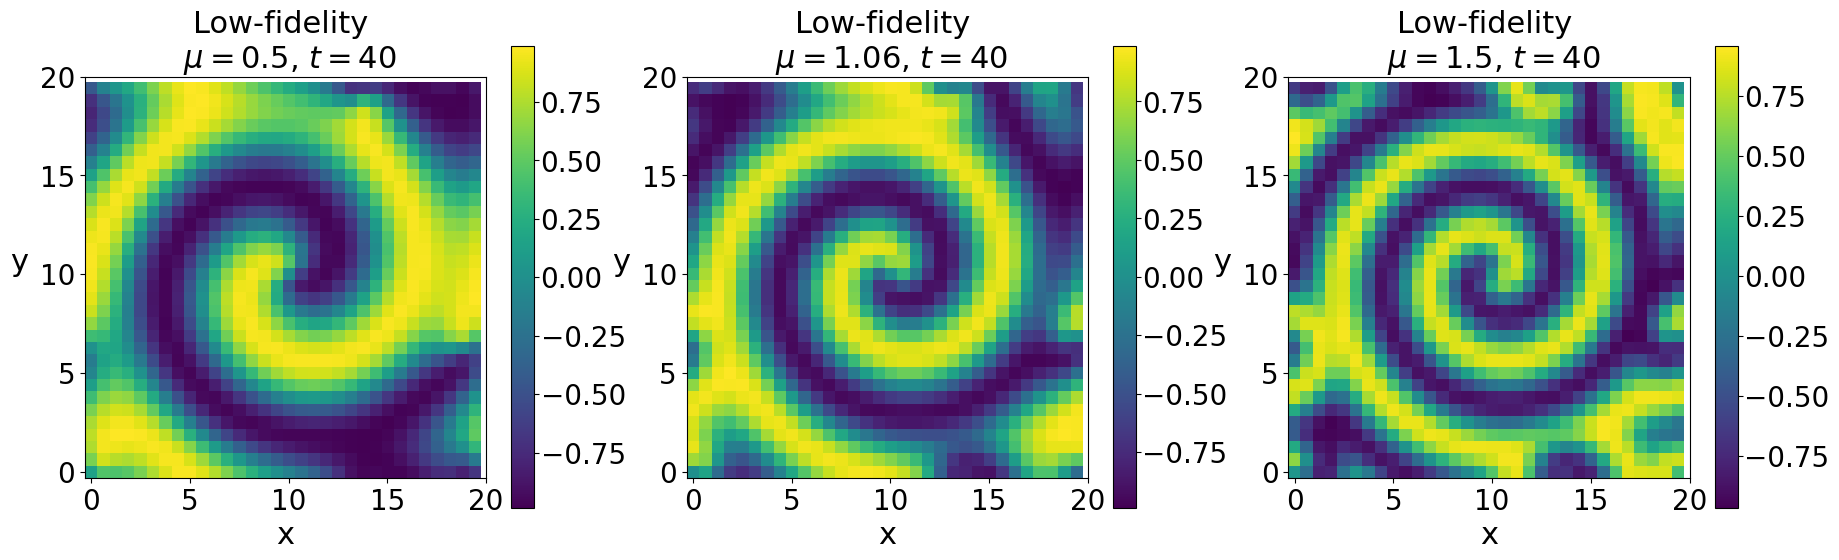

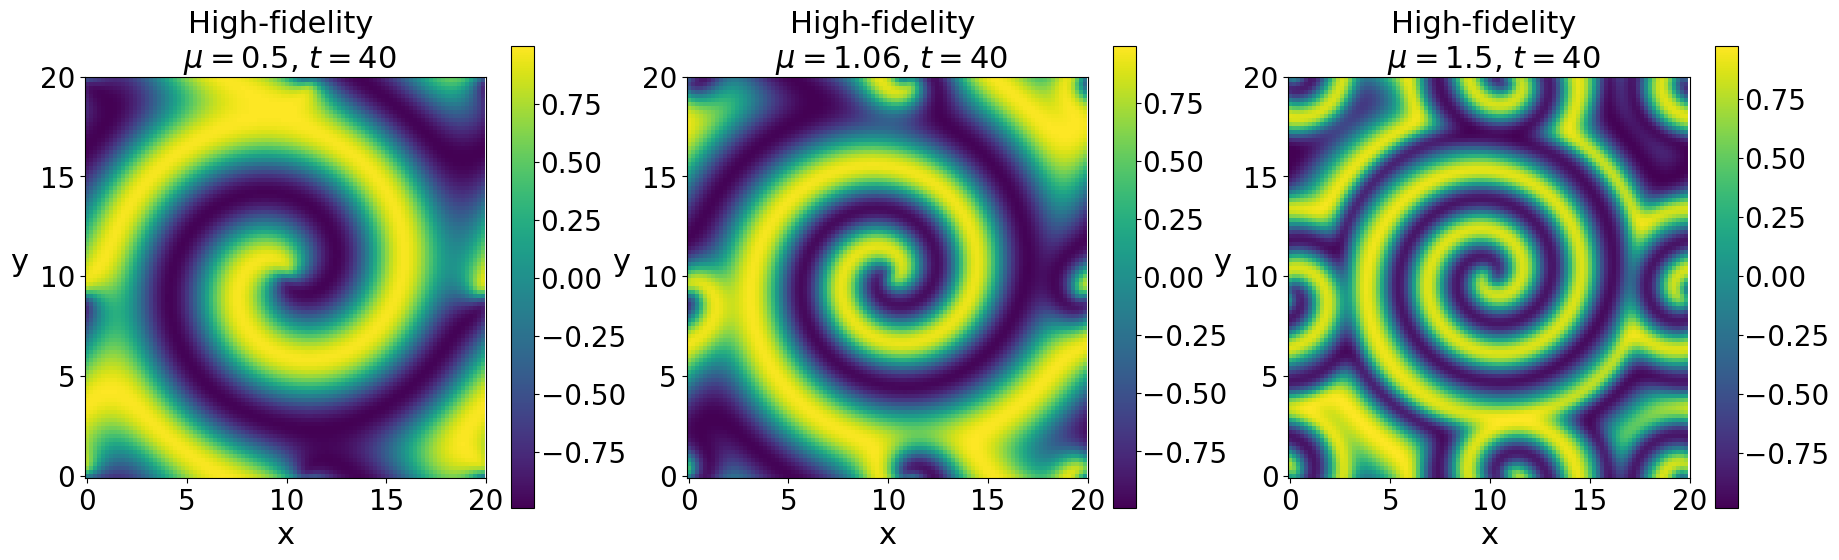

In [4]:
#########################   Visualize train data     ##########################
#########################         LF VS HF          ###########################

loc_lf = np.arange(0,Nx_lf+1,int(Nx_lf/4))
tick = np.arange(0,21,5)

#Low-fidelity training data
fig = plt.figure(figsize=(22,6))
idx_mu_list = [0, int(N_mu_train/2), -1]
for i,idx_mu in enumerate(idx_mu_list):
    ax = fig.add_subplot(131 + i)
    surf = ax.imshow(u_lf[:,:,-1,idx_mu], origin = 'lower')
    plt.xticks(loc_lf, tick,fontsize=20)
    plt.yticks(loc_lf, tick,fontsize=20)
    plt.xlabel('x', rotation = 0,fontsize = 22)
    plt.ylabel('y', rotation = 0, fontsize = 22, labelpad=15)
    plt.title('Low-fidelity \n $\mu = $' + str(round(mu_train[idx_mu],2)) + ', $t= $' + str(round(t_train[-1])) , fontsize = 22)
    cbar = plt.colorbar(surf)
    cbar.ax.tick_params(labelsize=20,pad=1)
    
loc = np.arange(0,Nx_hf+1,int(Nx_hf/4))
tick = np.arange(0,21,5)

#High-fidelity training data
fig = plt.figure(figsize=(22,6))
for i,idx_mu in enumerate(idx_mu_list):
    ax = fig.add_subplot(131 + i)
    surf = ax.imshow(u_hf[:,:,-1,idx_mu], origin = 'lower')
    plt.xticks(loc, tick,fontsize=20)
    plt.yticks(loc, tick,fontsize=20)
    plt.xlabel('x', rotation = 0,fontsize = 22)
    plt.ylabel('y', rotation = 0, fontsize = 22, labelpad=15)
    plt.title('High-fidelity \n $\mu = $' + str(round(mu_train[idx_mu],2)) + ', $t= $' + str(round(t_train[-1])) , fontsize = 22)
    cbar = plt.colorbar(surf)
    cbar.ax.tick_params(labelsize=20,pad=1)

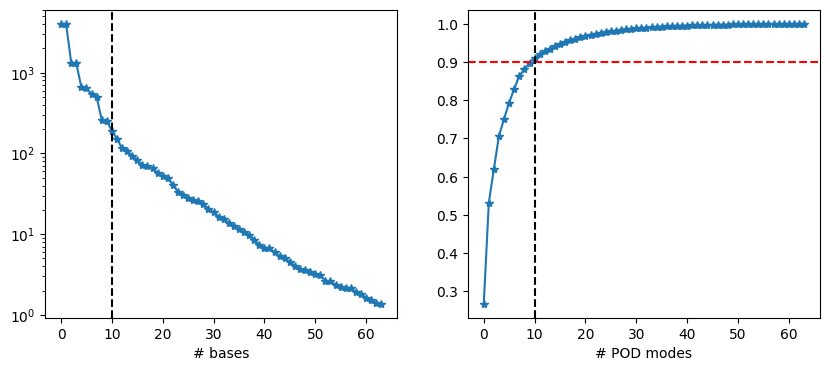

In [5]:
#########################   Proper Orthogonal Decomposition (POD)   ##########################
'''
Run POD on HF training data
'''
#Reshape for POD
u_hf_pod = np.reshape(u_hf, (N_hf, Nt_train*N_mu_train), 'F')

#POD on HF training data
POM_u, S_u = compute_randomized_SVD(u_hf_pod, config.N_POD_LARGE, N_hf, 1)

#We restrict the POD basis to the first 11 POD modes (90% of energy)
n_POD = 11

plt.figure(figsize = (10,4))
plt.subplot(121)
plt.plot(S_u,'*-')
plt.axvline(x = n_POD-1, color = 'k', linestyle = '--')
plt.yscale('log')
plt.xlabel('# bases')

plt.subplot(122)
plt.plot(np.cumsum(S_u)/np.sum(S_u),'*-')
plt.axhline(y = 0.9, color = 'r', linestyle = '--')
plt.axvline(x = n_POD-1, color = 'k', linestyle = '--')
plt.xlabel('# POD modes')
plt.show()

POM_u = POM_u[:,:n_POD]
S_u = S_u[:n_POD]

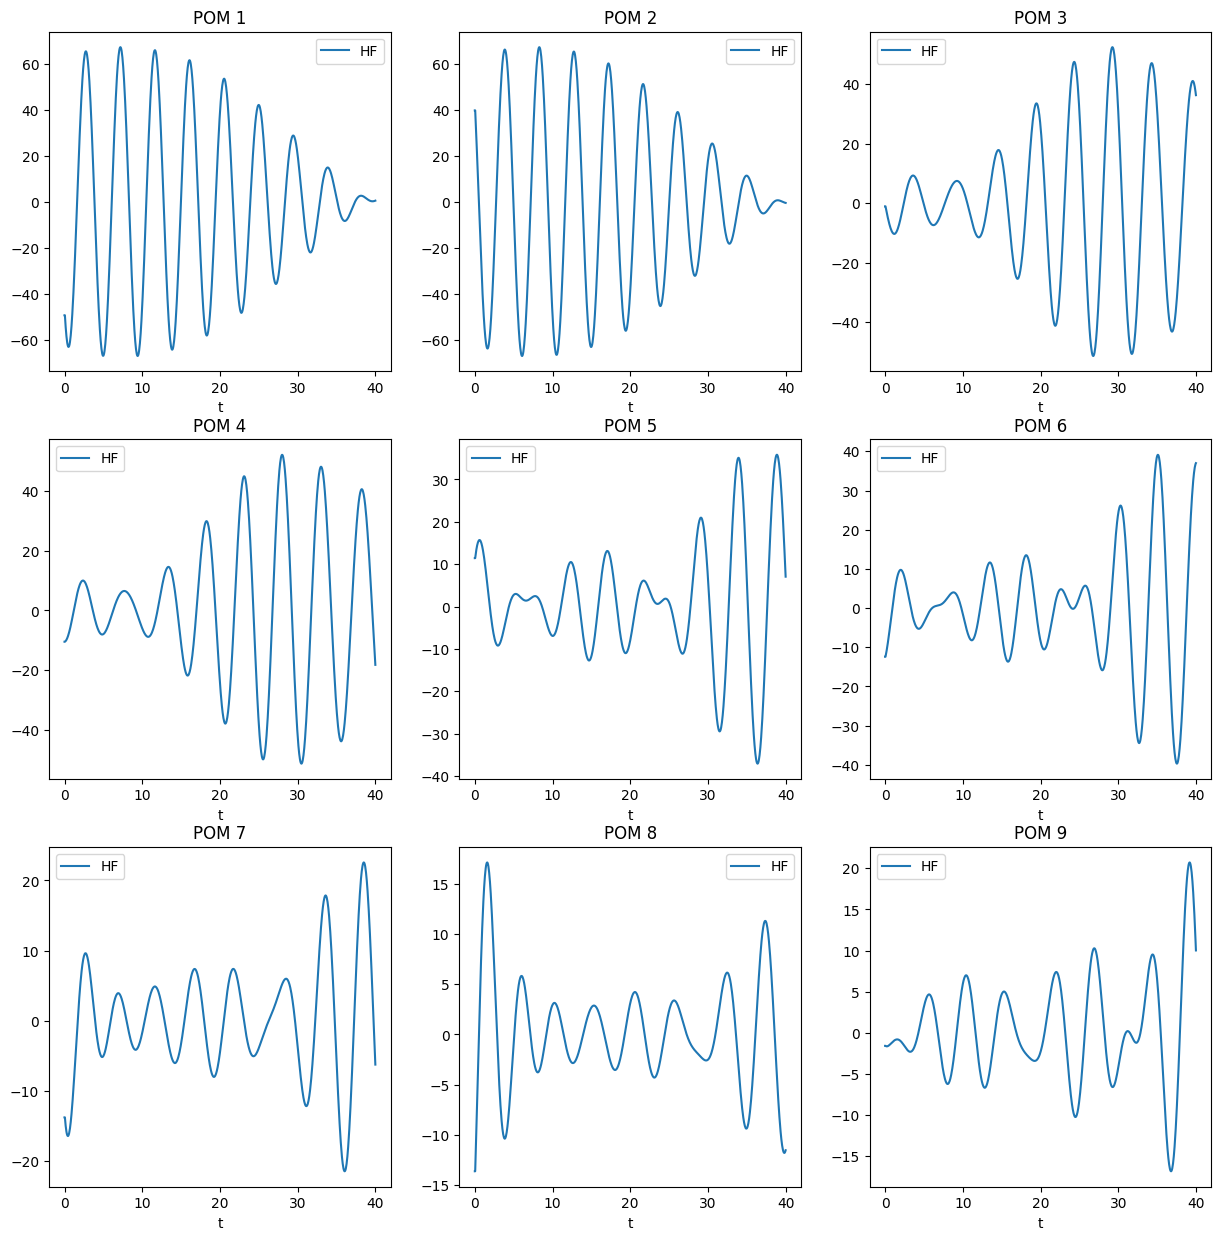

In [6]:
#########################   PROJECTION ONTO POD BASIS    ##########################
u_hf_test_pod = np.reshape(u_hf_test, (N_hf, Nt_test*N_mu_test), 'F')

uhf_train = u_hf_pod.T @ POM_u
uhf_test = u_hf_test_pod.T @ POM_u

#Reshape to make data suitable to LSTM network
uhf_train = np.reshape(uhf_train, (N_mu_train, Nt_train, -1))
uhf_test = np.reshape(uhf_test, (N_mu_test, Nt_test, -1))

#Plot POD coefficients: LF vs HF
fig = plt.figure(figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(331 + i)
    plt.plot(t_train, uhf_train[-1, :, i], label = 'HF')
    ax.title.set_text('POM ' + str(i+1))
    plt.xlabel('t')
    plt.legend()
plt.show()

In [7]:
#########################   LSTM NN PREPROCESS    ##########################
#Scaling
if config.SCALING:
    scale = np.max(np.abs(uhf_train))
    scale_param = np.max(np.abs(mu_train))
    scale_time = np.max(np.abs(t_train))
else:
    scale =  1.
    scale_param = 1.

In [8]:
#########################     MODEL 1: PREPROCESS    ##########################
###############################################################################
'''
As first model we consider only the time and the parameter as input
and a feed-forward neural network as model
'''

### Inputs (time and param)
# train
t_train_in = np.tile(t_train, N_mu_train) / scale_time
mu_train_in = np.repeat(mu_train, Nt_train) / scale_param
x1 = np.vstack((t_train_in, mu_train_in)).transpose()
# test
t_test_in = np.tile(t_test, N_mu_test) / scale_time
mu_test_in = np.repeat(mu_test, Nt_test) / scale_param
x1_test = np.vstack((t_test_in, mu_test_in)).transpose()

### Output (HF solutions)
#train
y1 = uhf_train.reshape(-1,n_POD) / scale
#test
y1_test = uhf_test.reshape(-1,n_POD) / scale
yhf_test = uhf_test.reshape(-1,n_POD) / scale

### Reshape to be suited for time-series
t_train_lstm = np.tile(t_train, N_mu_train).T.reshape(N_mu_train,-1,1) / scale_time
mu_train_lstm = np.repeat(mu_train, Nt_train).reshape(N_mu_train,-1,1) / scale_param
x1_lstm = np.concatenate((t_train_lstm, mu_train_lstm), axis = 2)
y1_lstm = uhf_train / scale

t_test_lstm = np.tile(t_test, N_mu_test).T.reshape(N_mu_test,-1,1) / scale_time
mu_test_lstm = np.repeat(mu_test, Nt_test).reshape(N_mu_test,-1,1) / scale_param
x1_test_lstm = np.concatenate((t_test_lstm, mu_test_lstm), axis = 2)

y1_test_lstm = uhf_test / scale
yhf_test_lstm = uhf_test / scale

x1_lstm_seq, y1_lstm_seq = sliding_windows(x1_lstm, y1_lstm, config.HPARAMS['sequence_length'], config.HPARAMS['sequence_freq'])

#Retrieve hyperparameters
n_sim = config.N_SIMULATIONS
params1 = config.HPARAMS
params1["model_type_encoder"] = "Dense"
params1["model_type_decoder"] = "LSTM"

<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:54: SyntaxWarning: invalid escape sequence '\p'
<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:54: SyntaxWarning: invalid escape sequence '\p'
/var/folders/53/bl81mrf10js0l8nbft96cn9r0000gr/T/ipykernel_83162/2896612805.py:49: SyntaxWarning: invalid escape sequence '\m'
  plt.suptitle(f'Model 1: $\mu ={mu_test[idx_test]}$', fontsize = 16)
/var/folders/53/bl81mrf10js0l8nbft96cn9r0000gr/T/ipykernel_83162/2896612805.py:54: SyntaxWarning: invalid escape sequence '\p'
  plt.fill_between(t_test, mean_sim1[idx_test,:, i] -2*std_sim1[idx_test,:, i], mean_sim1[idx_test,:, i] + 2*std_sim1[idx_test,:, i], color='lightblue', alpha=0.5, label='$\pm2$ std')
2025-10-16 14:37:36.283346: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-10-16 14:37:36.283376: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-10-16 14:37:36.283383: I metal_plugin/src/device/metal_device.cc:313] maxCa

sim 1/30
Loading weights from: ./models/model1_sim_0.weights.h5
sim 2/30
Loading weights from: ./models/model1_sim_1.weights.h5
sim 3/30
Loading weights from: ./models/model1_sim_2.weights.h5
sim 4/30
Loading weights from: ./models/model1_sim_3.weights.h5
sim 5/30
Loading weights from: ./models/model1_sim_4.weights.h5
sim 6/30
Loading weights from: ./models/model1_sim_5.weights.h5
sim 7/30
Loading weights from: ./models/model1_sim_6.weights.h5
sim 8/30
Loading weights from: ./models/model1_sim_7.weights.h5
sim 9/30
Loading weights from: ./models/model1_sim_8.weights.h5
sim 10/30
Loading weights from: ./models/model1_sim_9.weights.h5
sim 11/30
Loading weights from: ./models/model1_sim_10.weights.h5
sim 12/30
Loading weights from: ./models/model1_sim_11.weights.h5
sim 13/30
Loading weights from: ./models/model1_sim_12.weights.h5
sim 14/30
Loading weights from: ./models/model1_sim_13.weights.h5
sim 15/30
Loading weights from: ./models/model1_sim_14.weights.h5
sim 16/30
Loading weights fro

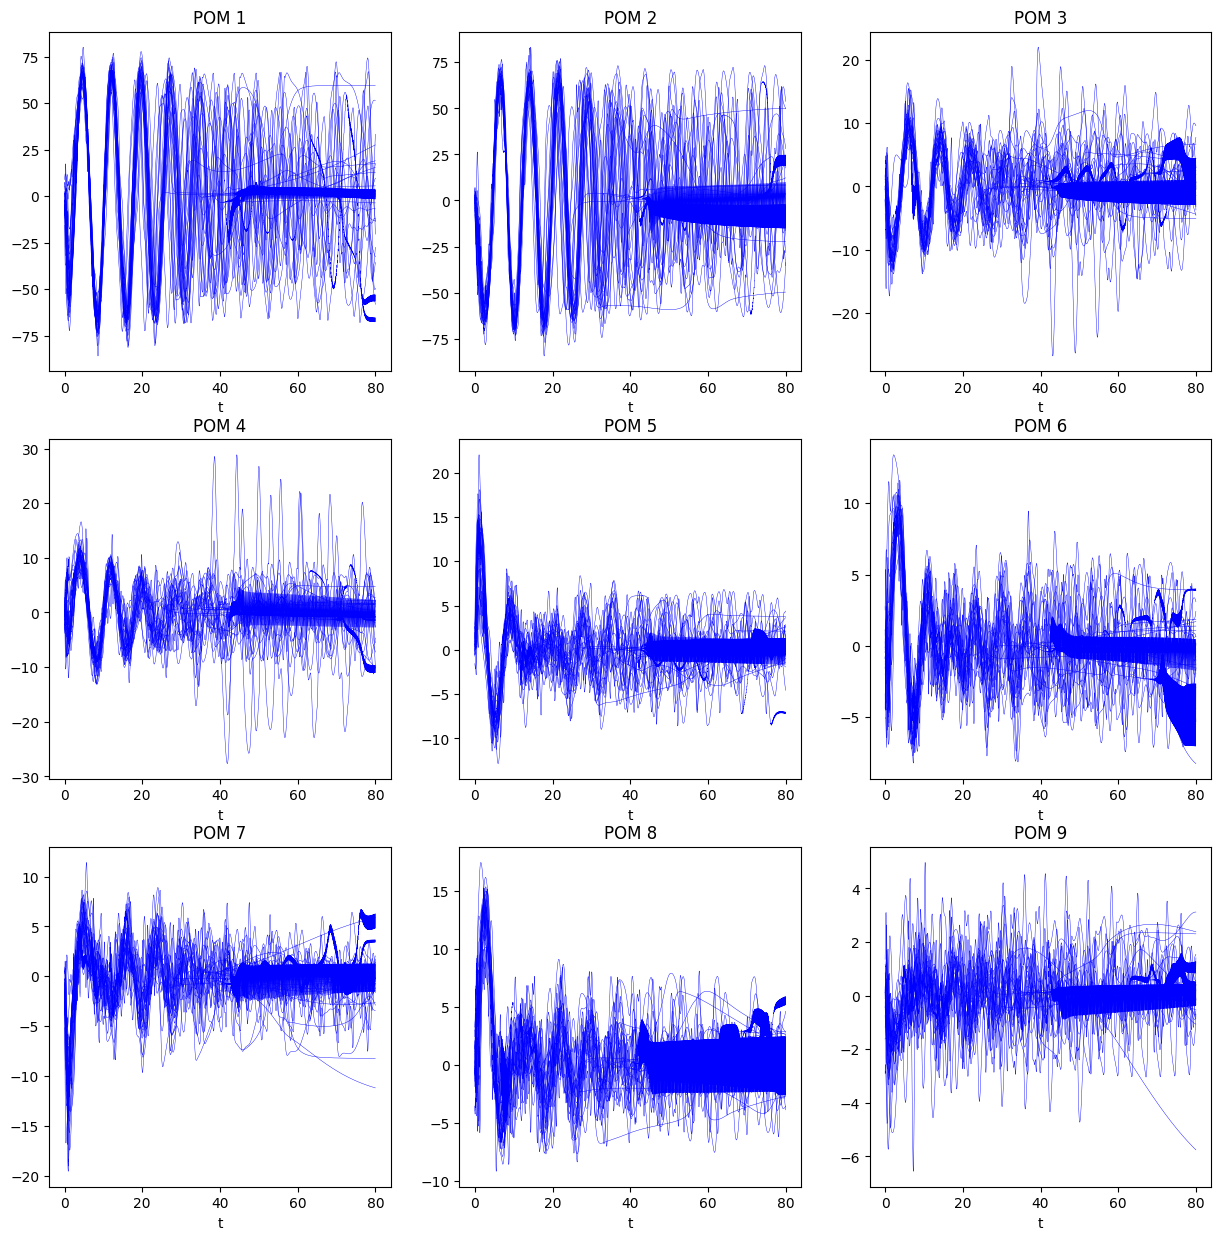

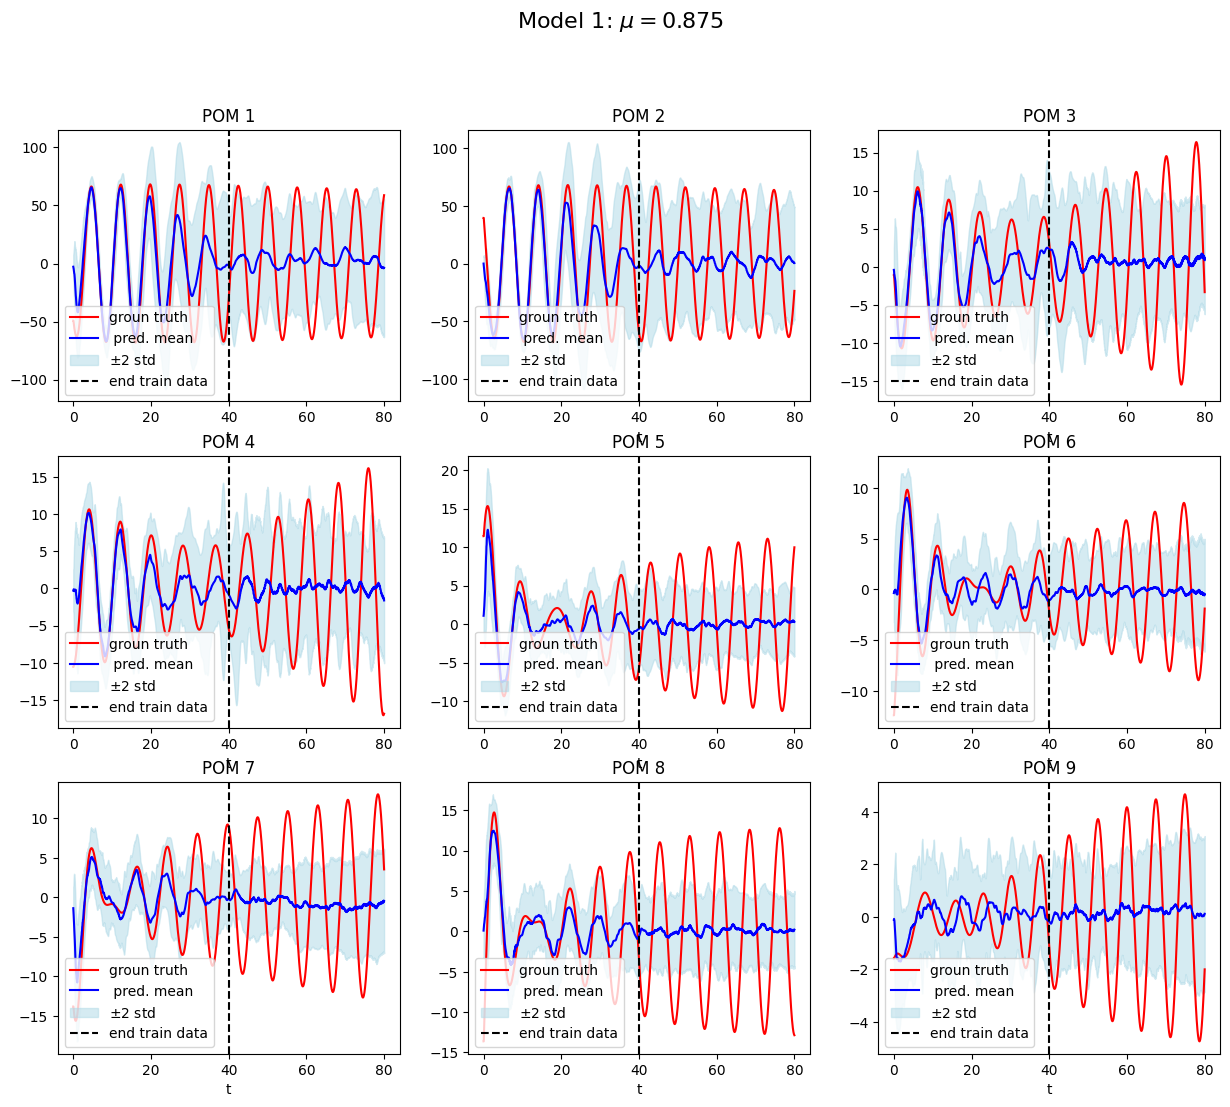

In [9]:
#########################     MODEL 1    ##########################
#########################      TRAIN     ##########################

pred_sim1 = []
model1_list = []

input_dim1 = 2 #(time, parameter)
latent_dim1 = 2 
output_dim1 = n_POD # Number of HF POD modes
idx_test = 0  # show results for the first test parameter

fig = plt.figure(figsize=(15,15))
for i in range(config.N_SIMULATIONS):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=config.PATIENCE, restore_best_weights=True)

    print('sim ' + str(i+1) + '/' + str(n_sim))
    #### MODEL 1 - (time, parameter) -> HF-POD coefficients
    model1 = MultifidelityNetwork(params1, input_dim = input_dim1, latent_dim = latent_dim1, output_dim = output_dim1, prev_models = [], prev_inputs = [])
    name = config.MODEL_PATH + 'model1_sim_' + str(i)
    if config.TRAIN_MODELS:
        model1.autoencoder.compile(loss=custom_loss,optimizer=params1['opt'])
        tf.random.set_seed(config.SEED + i)
        np.random.seed(config.SEED + i)
        hist1 = model1.autoencoder.fit(x1_lstm_seq,y1_lstm_seq,epochs=config.N_EPOCHS,batch_size=Nt_train,verbose=1,callbacks=[early_stopping])
    else:
        model1.load_weights(name+ '.weights.h5')

    #Predict and append results
    y_pred1_test = model1.predict(x1_test_lstm) * scale
    pred_sim1.append(y_pred1_test)
    model1_list.append(model1)

    if config.SAVE_MODELS:
        model1.save_weights(name + '.weights.h5')

    # Plot prediction of the first simulation for the ensemble
    for j in range(9):
        ax = plt.subplot(331 + j)
        plt.plot(t_test, y_pred1_test[idx_test,:, j], label = 'HF', color = 'blue',  linewidth = 0.3)
        ax.title.set_text('POM ' + str(j+1))
        plt.xlabel('t')

# Compute mean and std for UQ from the ensemble
mean_sim1 = np.mean(np.array(pred_sim1), axis = 0)
std_sim1 = np.std(np.array(pred_sim1), axis = 0)

# Plot results
fig = plt.figure(figsize=(15,12))
plt.suptitle(f'Model 1: $\mu ={mu_test[idx_test]}$', fontsize = 16)
for i in range(9):
    ax = plt.subplot(331 + i)
    plt.plot(t_test, y1_test_lstm[idx_test,:, i] * scale, label = 'groun truth', color = 'red')
    plt.plot(t_test, mean_sim1[idx_test,:, i], label = ' pred. mean', color = 'blue')
    plt.fill_between(t_test, mean_sim1[idx_test,:, i] -2*std_sim1[idx_test,:, i], mean_sim1[idx_test,:, i] + 2*std_sim1[idx_test,:, i], color='lightblue', alpha=0.5, label='$\pm2$ std')
    ax.title.set_text('POM ' + str(i+1))
    plt.xlabel('t')
    plt.axvline(x = T_train, color = 'k', linestyle = '--', label = 'end train data')
    plt.legend(loc = 'lower left')
plt.show()

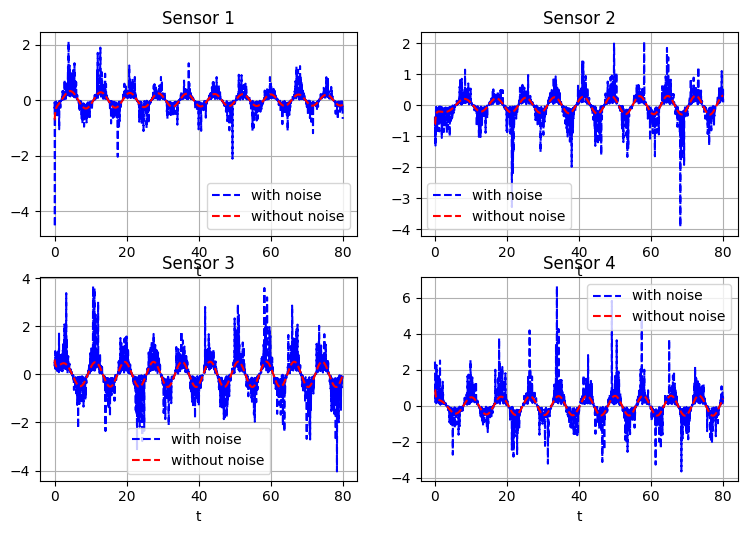

In [10]:
#########################     MODEL 2    ##########################
#########################   PREPROCESS   ##########################
'''
As second model we consider, in addition to time and parameter information, 
the low-fidelity solution of boundary vertexes, representing noisy sensors
'''

np.random.seed(config.SEED)
u_hf_noise = u_hf * (np.random.lognormal(mean=0, sigma=config.NOISE_LEVEL, size=u_hf.shape))
u_hf_test_noise = u_hf_test * (np.random.lognormal(mean=0, sigma=config.NOISE_LEVEL, size=u_hf_test.shape))

# 4 vertexes of the domain
x2_sensors = np.stack((u_hf_noise[0,0,:,:], 
                        u_hf_noise[0,-1,:,:], 
                        u_hf_noise[-1,0,:,:], 
                        u_hf_noise[-1,-1,:,:]), axis = 0).swapaxes(0, 2)

x2_sensors_test = np.stack((u_hf_test_noise[0,0,:,:], 
                            u_hf_test_noise[0,-1,:,:], 
                            u_hf_test_noise[-1,0,:,:], 
                            u_hf_test_noise[-1,-1,:,:]), axis = 0).swapaxes(0, 2)

x2_sensors_without_noise = np.stack((u_hf[0,0,:,:],
                            u_hf[0,-1,:,:],
                            u_hf[-1,0,:,:],
                            u_hf[-1,-1,:,:]), axis = 0).swapaxes(0, 2)
x2_sensors_test_without_noise = np.stack((u_hf_test[0,0,:,:],
                            u_hf_test[0,-1,:,:],
                            u_hf_test[-1,0,:,:],
                            u_hf_test[-1,-1,:,:]), axis = 0).swapaxes(0, 2) 
n_sensors_tot = 4

#Plot noisy solution at sensors locations (domain vertexes)
plt.figure(figsize = [9,9])
for i in range(n_sensors_tot):
    plt.subplot(321 + i)
    plt.plot(t_test, x2_sensors_test[0,:,i], linestyle = '--', color = 'blue', label = 'with noise')
    plt.plot(t_test, x2_sensors_test_without_noise[0,:,i], linestyle = '--', color = 'red', label = 'without noise')
    plt.xlabel('t')
    plt.grid()
    plt.legend()
    plt.title('Sensor ' + str(i+1))
plt.show()

### Reshape and rescale data
### Input
x2 = x2_sensors.reshape(-1, x2_sensors.shape[2])
x2_lstm = x2_sensors
x2_test_lstm = x2_sensors_test

### Output: the ouput is the same (i.e., HF solution)
y2_lstm = y1_lstm 
y2_test_lstm = y1_test_lstm\
### Reshape to be suited for time-series
x2_lstm_seq, y2_lstm_seq = sliding_windows(x2_lstm, y2_lstm, config.HPARAMS['sequence_length'], config.HPARAMS['sequence_freq'])

# We keep the same hyperparameters at each level
# We just update the encoder (we use LSTM instead of Dense) as now we are having time-series as inputs
params2 = params1
params2['model_type_encoder'] = 'LSTM'
params2['model_type_decoder'] = 'LSTM'

<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:54: SyntaxWarning: invalid escape sequence '\p'
<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:54: SyntaxWarning: invalid escape sequence '\p'
/var/folders/53/bl81mrf10js0l8nbft96cn9r0000gr/T/ipykernel_83162/4101380719.py:49: SyntaxWarning: invalid escape sequence '\m'
  plt.suptitle(f'Model 2: $\mu ={mu_test[idx_test]}$', fontsize = 16)
/var/folders/53/bl81mrf10js0l8nbft96cn9r0000gr/T/ipykernel_83162/4101380719.py:54: SyntaxWarning: invalid escape sequence '\p'
  plt.fill_between(t_test, mean_sim2[idx_test,:, i] -2*std_sim2[idx_test,:, i], mean_sim2[idx_test,:, i] + 2*std_sim2[idx_test,:, i], color='lightblue', alpha=0.5, label='$\pm2$ std')


sim 1/30
Loading weights from: ./models/model2_sim_0.weights.h5
sim 2/30
Loading weights from: ./models/model2_sim_1.weights.h5
sim 3/30
Loading weights from: ./models/model2_sim_2.weights.h5
sim 4/30
Loading weights from: ./models/model2_sim_3.weights.h5
sim 5/30
Loading weights from: ./models/model2_sim_4.weights.h5
sim 6/30
Loading weights from: ./models/model2_sim_5.weights.h5
sim 7/30
Loading weights from: ./models/model2_sim_6.weights.h5
sim 8/30
Loading weights from: ./models/model2_sim_7.weights.h5
sim 9/30
Loading weights from: ./models/model2_sim_8.weights.h5
sim 10/30
Loading weights from: ./models/model2_sim_9.weights.h5
sim 11/30
Loading weights from: ./models/model2_sim_10.weights.h5
sim 12/30
Loading weights from: ./models/model2_sim_11.weights.h5
sim 13/30
Loading weights from: ./models/model2_sim_12.weights.h5
sim 14/30
Loading weights from: ./models/model2_sim_13.weights.h5
sim 15/30
Loading weights from: ./models/model2_sim_14.weights.h5
sim 16/30
Loading weights fro

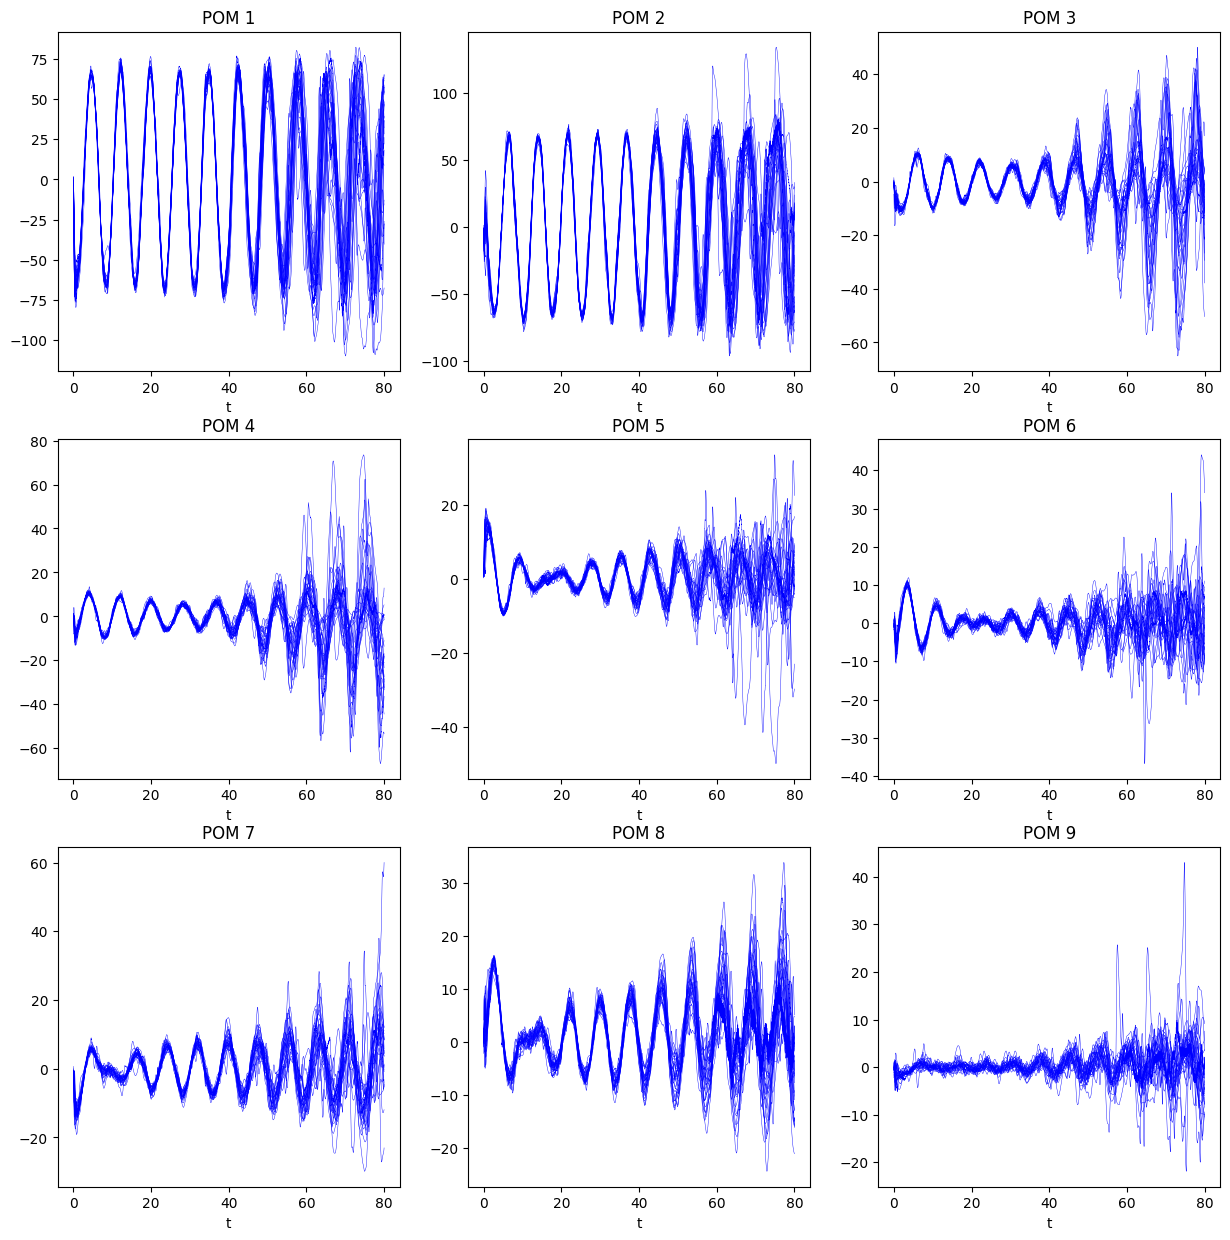

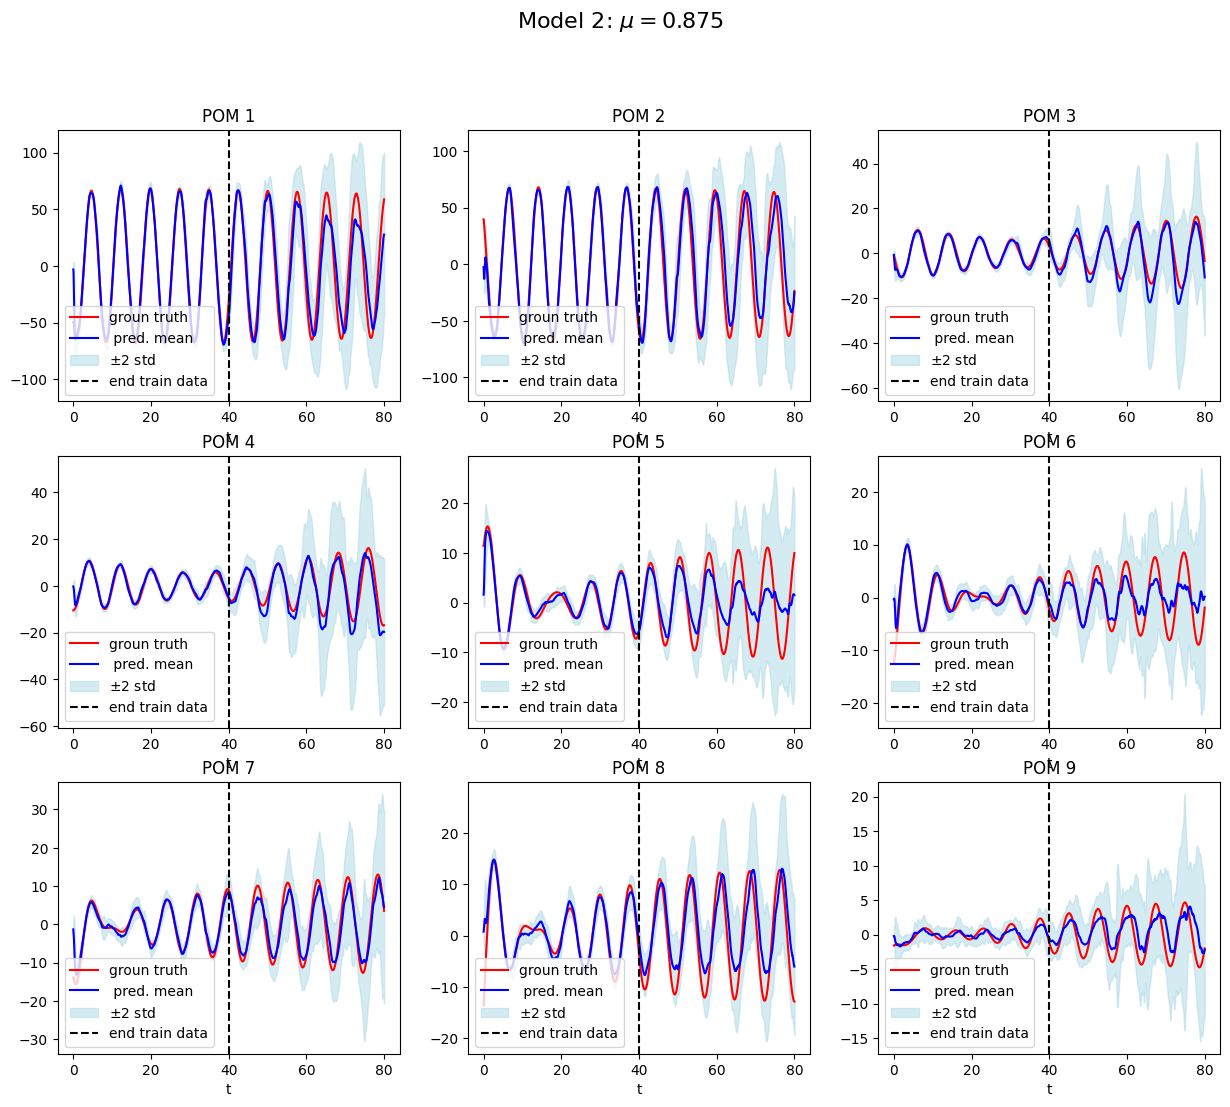

In [11]:
#########################     MODEL 2    ##########################
#########################      TRAIN     ##########################

pred_sim2 = []
model2_list = []

input_dim2 = n_sensors_tot 
latent_dim2 = n_sensors_tot
output_dim2 = n_POD

fig = plt.figure(figsize=(15,15))

for i in range(config.N_SIMULATIONS):
    print('sim ' + str(i+1) + '/' + str(n_sim))
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=config.PATIENCE, restore_best_weights=True)

    #### MODEL 2 - (time, parameter, sensors) -> HF-POD coefficients
    model2 = MultifidelityNetwork(params2, input_dim = input_dim2, latent_dim = latent_dim2, output_dim = output_dim2, prev_models = [model1_list[i]], prev_inputs = [x1])
    name = config.MODEL_PATH + 'model2_sim_' + str(i)
    if config.TRAIN_MODELS:
        model2.autoencoder.compile(loss=custom_loss,optimizer=params2['opt'])
        tf.random.set_seed(config.SEED + i)
        np.random.seed(config.SEED + i)
        # hist2 = model2.autoencoder.fit(x2,y2,epochs=Nepo,batch_size=N_mu_train,verbose=0,callbacks=[early_stopping])
        hist2 = model2.autoencoder.fit([x1_lstm_seq, x2_lstm_seq],y2_lstm_seq,epochs=config.N_EPOCHS,batch_size=x2_lstm_seq.shape[0],verbose=1,callbacks=[early_stopping])
    else:
        model2.load_weights(name + '.weights.h5')
    model2_list.append(model2)
    if config.SAVE_MODELS:
        model2.save_weights(name + '.weights.h5')

    #Predict and append results
    y_pred2_test = model2.predict([x1_test_lstm, x2_test_lstm]) * scale
    pred_sim2.append(y_pred2_test)
    
    # Plot prediction of the first simulation for the ensemble
    for j in range(9):
        ax = plt.subplot(331 + j)
        plt.plot(t_test, y_pred2_test[idx_test,:, j], label = 'HF', color = 'blue',  linewidth = 0.3)
        ax.title.set_text('POM ' + str(j+1))
        plt.xlabel('t')

# Compute mean and std for UQ from the ensemble
mean_sim2 = np.mean(np.array(pred_sim2), axis = 0)
std_sim2 = np.std(np.array(pred_sim2), axis = 0)

# Plot results
fig = plt.figure(figsize=(15,12))
plt.suptitle(f'Model 2: $\mu ={mu_test[idx_test]}$', fontsize = 16)
for i in range(9):
    ax = plt.subplot(331 + i)
    plt.plot(t_test, y2_test_lstm[idx_test,:, i] * scale, label = 'groun truth', color = 'red')
    plt.plot(t_test, mean_sim2[idx_test,:, i], label = ' pred. mean', color = 'blue')
    plt.fill_between(t_test, mean_sim2[idx_test,:, i] -2*std_sim2[idx_test,:, i], mean_sim2[idx_test,:, i] + 2*std_sim2[idx_test,:, i], color='lightblue', alpha=0.5, label='$\pm2$ std')
    ax.title.set_text('POM ' + str(i+1))
    plt.xlabel('t')
    plt.axvline(x = T_train, color = 'k', linestyle = '--', label = 'end train data')
    plt.legend(loc = 'lower left')
plt.show()

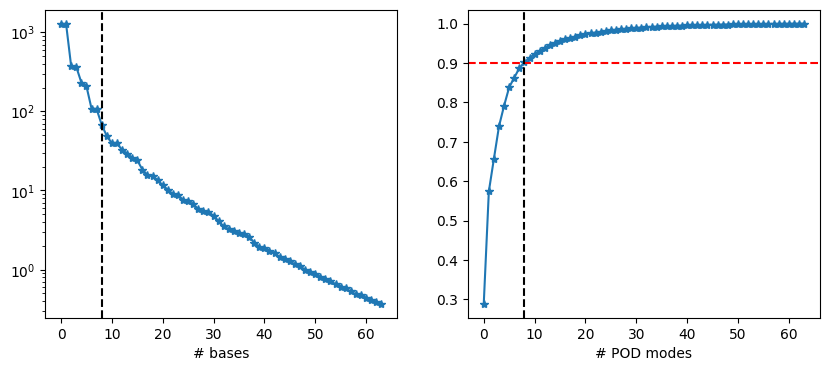

In [12]:
#########################   Proper Orthogonal Decomposition (POD)   ##########################
'''
Run POD on LF training data
'''
u_lf_pod = np.reshape(u_lf, (N_lf, Nt_train*N_mu_train), 'F')

#POD on HF training data
POM_u_lf, S_u_lf  = compute_randomized_SVD(u_lf_pod, config.N_POD_LARGE, N_lf, 1)

#We restrict the POD basis to the first 9 POD modes
n_POD_lf = 9

plt.figure(figsize = (10,4))
plt.subplot(121)
plt.plot(S_u_lf,'*-')
plt.axvline(x = n_POD_lf-1, color = 'k', linestyle = '--')
plt.yscale('log')
plt.xlabel('# bases')

plt.subplot(122)
plt.plot(np.cumsum(S_u_lf/np.sum(S_u_lf)),'*-')
plt.axhline(y = 0.9, color = 'r', linestyle = '--')
plt.axvline(x = n_POD_lf-1, color = 'k', linestyle = '--')
plt.xlabel('# POD modes')
plt.show()

POM_u_lf = POM_u_lf[:,:n_POD_lf]
S_u_lf = S_u_lf[:n_POD_lf]

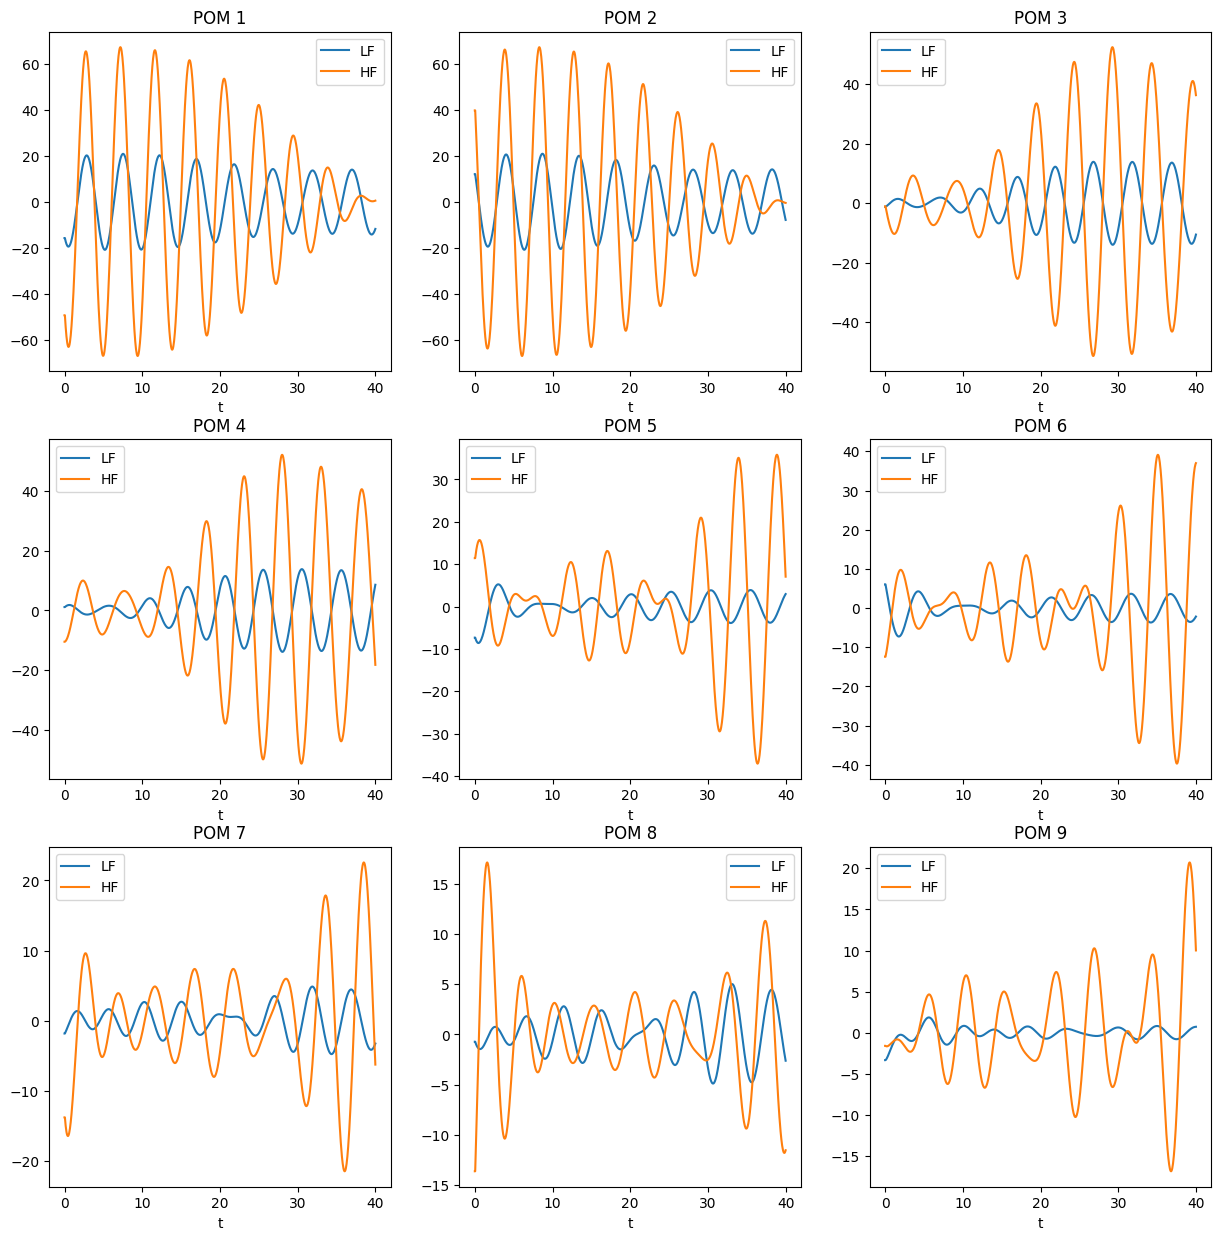

In [13]:
#########################   PROJECTION ONTO POD BASIS    ##########################
u_lf_test_pod = np.reshape(u_lf_test, (N_lf, Nt_lf_test*N_mu_test), 'F')

ulf_train = u_lf_pod.T @ POM_u_lf
ulf_test = u_lf_test_pod.T @ POM_u_lf

#Reshape to make data suitable to LSTM network
ulf_train = np.reshape(ulf_train, (N_mu_train, Nt_train, -1))
ulf_test = np.reshape(ulf_test, (N_mu_test, Nt_lf_test, -1))

#Plot POD coefficients: LF vs HF
fig = plt.figure(figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(331 + i)
    plt.plot(t_train, ulf_train[-1,:,i], label = 'LF')
    plt.plot(t_train, uhf_train[-1, :, i], label = 'HF')
    ax.title.set_text('POM ' + str(i+1))
    plt.xlabel('t')
    plt.legend()
plt.show()

In [14]:
#########################     MODEL 3    ##########################
#########################   PREPROCESS   ##########################
'''
As third model we consider, in addition to time, parameter and sensors information, the POD coordinates of the full low-fidelity solution
'''
#train
x3_lstm = ulf_train / scale
y3_lstm = uhf_train / scale

#test
x3_test_lstm = ulf_test / scale
y3_test_lstm = uhf_test / scale

# We keep the same hyperparameters at each level
params3 = params1
params3['model_type_encoder'] = 'LSTM'
params3['model_type_decoder'] = 'LSTM'

x3_lstm_seq, y3_lstm_seq = sliding_windows(x3_lstm, y3_lstm, params3['sequence_length'], params3['sequence_freq'])

<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:52: SyntaxWarning: invalid escape sequence '\p'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:52: SyntaxWarning: invalid escape sequence '\p'
/var/folders/53/bl81mrf10js0l8nbft96cn9r0000gr/T/ipykernel_83162/3898359849.py:47: SyntaxWarning: invalid escape sequence '\m'
  plt.suptitle(f'Model 3: $\mu ={mu_test[idx_test]}$', fontsize = 16)
/var/folders/53/bl81mrf10js0l8nbft96cn9r0000gr/T/ipykernel_83162/3898359849.py:52: SyntaxWarning: invalid escape sequence '\p'
  plt.fill_between(t_test, mean_sim3[idx_test,:, i] -2*std_sim3[idx_test,:, i], mean_sim3[idx_test,:, i] + 2*std_sim3[idx_test,:, i], color='lightblue', alpha=0.5, label='$\pm2$ std')


sim 1/30
Loading weights from: ./models/model3_sim_0.weights.h5
sim 2/30
Loading weights from: ./models/model3_sim_1.weights.h5
sim 3/30
Loading weights from: ./models/model3_sim_2.weights.h5
sim 4/30
Loading weights from: ./models/model3_sim_3.weights.h5
sim 5/30
Loading weights from: ./models/model3_sim_4.weights.h5
sim 6/30
Loading weights from: ./models/model3_sim_5.weights.h5
sim 7/30
Loading weights from: ./models/model3_sim_6.weights.h5
sim 8/30
Loading weights from: ./models/model3_sim_7.weights.h5
sim 9/30
Loading weights from: ./models/model3_sim_8.weights.h5
sim 10/30
Loading weights from: ./models/model3_sim_9.weights.h5
sim 11/30
Loading weights from: ./models/model3_sim_10.weights.h5
sim 12/30
Loading weights from: ./models/model3_sim_11.weights.h5
sim 13/30
Loading weights from: ./models/model3_sim_12.weights.h5
sim 14/30
Loading weights from: ./models/model3_sim_13.weights.h5
sim 15/30
Loading weights from: ./models/model3_sim_14.weights.h5
sim 16/30
Loading weights fro

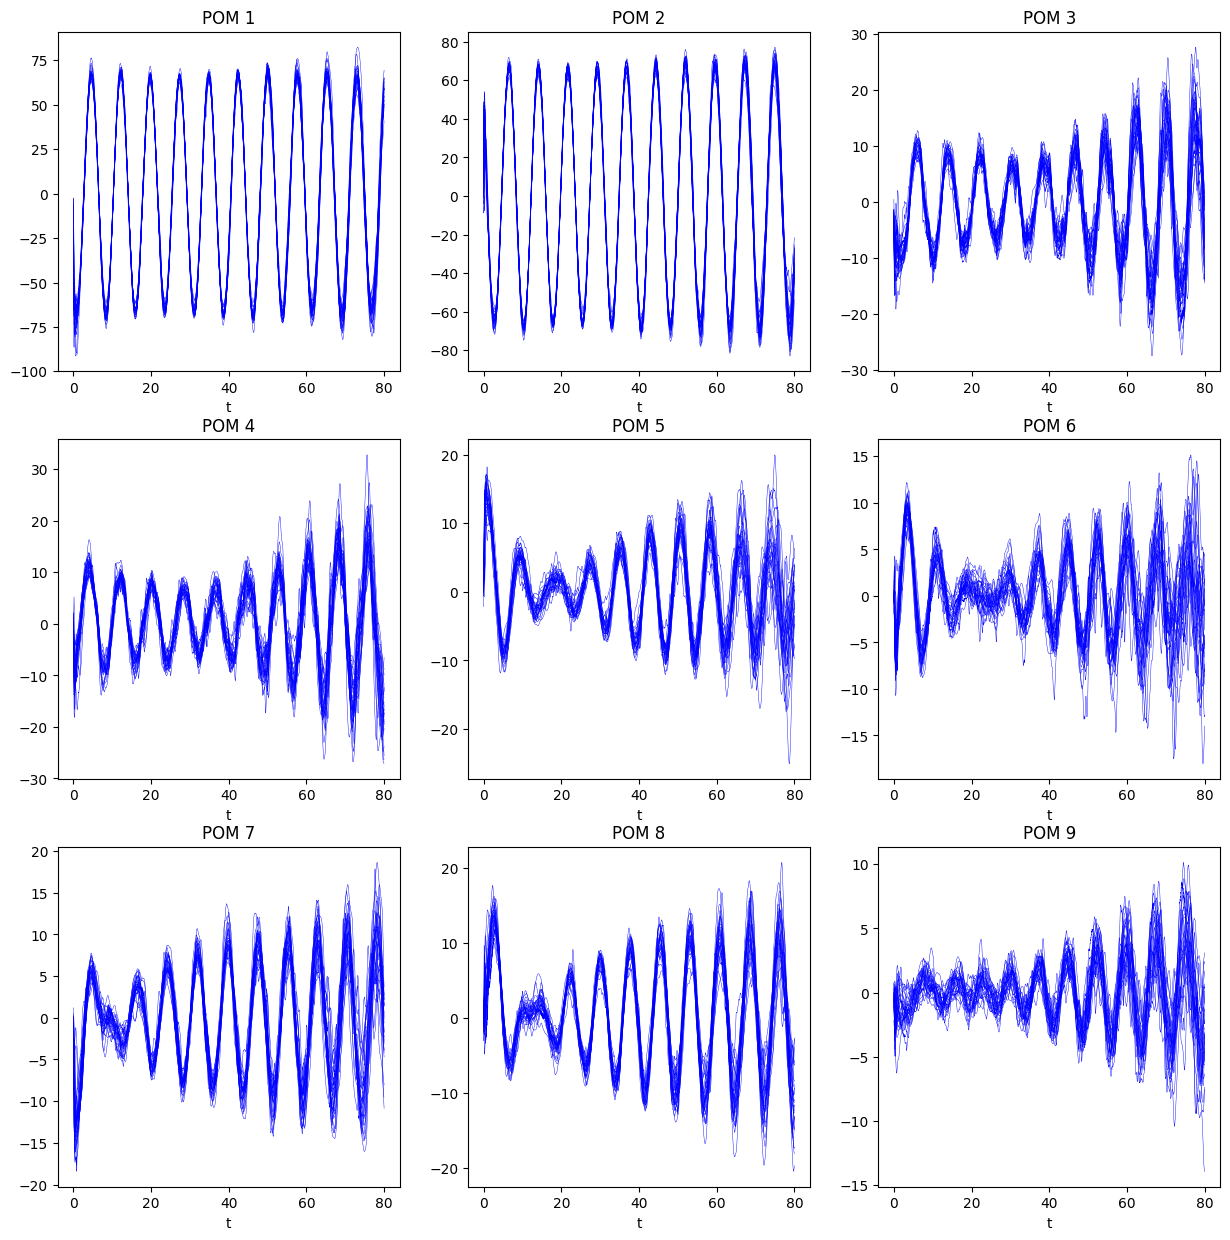

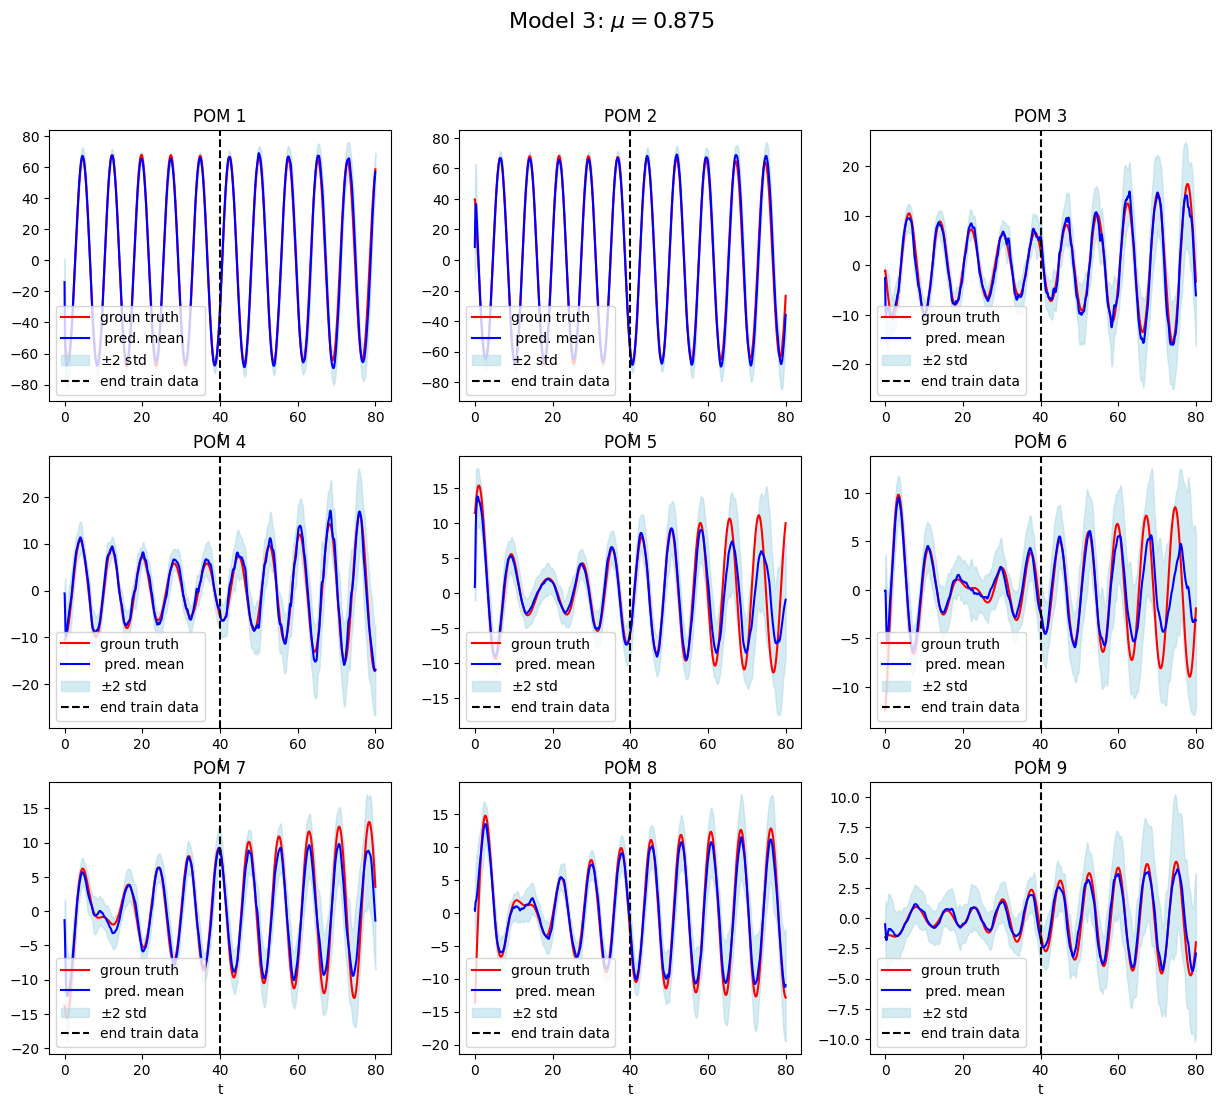

In [15]:
#########################     MODEL 3    ##########################
#########################      TRAIN     ##########################
pred_sim3 = []
pred_sim3_train = []
model3_list = []

input_dim3 = n_POD_lf
latent_dim3 = 4
output_dim3 = n_POD

fig = plt.figure(figsize=(15,15))

for i in range(config.N_SIMULATIONS):
    print('sim ' + str(i+1) + '/' + str(n_sim))
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=config.PATIENCE, restore_best_weights=True)
    #### MODEL 3 - (time, parameter, sensors, LF-POD coeffs.) -> HF-POD coeffs
    model3 = MultifidelityNetwork(params3, input_dim = input_dim3, latent_dim = latent_dim3, output_dim = output_dim3, prev_models = [model1_list[i], model2_list[i]], prev_inputs = [x1, x2])
    name = config.MODEL_PATH + 'model3_sim_' + str(i)
    if config.TRAIN_MODELS:
        model3.autoencoder.compile(loss=custom_loss,optimizer=params3['opt'])
        tf.random.set_seed(config.SEED + i)
        np.random.seed(config.SEED + i)
        hist3 = model3.autoencoder.fit([x1_lstm_seq, x2_lstm_seq, x3_lstm_seq],y3_lstm_seq,epochs=config.N_SIMULATIONS,batch_size=x3_lstm_seq.shape[0],verbose=1,callbacks=[early_stopping])
    else:
        model3.load_weights(name + '.weights.h5')

    if config.SAVE_MODELS:
        model3.save_weights(name + '.weights.h5')
    #Predict and append results
    y_pred3_test = model3.predict([x1_test_lstm, x2_test_lstm, x3_test_lstm]) * scale
    pred_sim3.append(y_pred3_test)
    model3_list.append(model3)
    
    # Plot prediction of the first simulation for the ensemble
    for j in range(9):
        ax = plt.subplot(331 + j)
        plt.plot(t_test, y_pred3_test[idx_test,:, j], label = 'HF', color = 'blue',  linewidth = 0.3)
        ax.title.set_text('POM ' + str(j+1))
        plt.xlabel('t')

# compute mean and std for UQ from the ensemble
mean_sim3 = np.mean(np.array(pred_sim3), axis = 0)
std_sim3 = np.std(np.array(pred_sim3), axis = 0)

# Plot results
fig = plt.figure(figsize=(15,12))
plt.suptitle(f'Model 3: $\mu ={mu_test[idx_test]}$', fontsize = 16)
for i in range(9):  
    ax = plt.subplot(331 + i)
    plt.plot(t_test, y3_test_lstm[idx_test,:, i] * scale, label = 'groun truth', color = 'red')
    plt.plot(t_test, mean_sim3[idx_test,:, i], label = ' pred. mean', color = 'blue')
    plt.fill_between(t_test, mean_sim3[idx_test,:, i] -2*std_sim3[idx_test,:, i], mean_sim3[idx_test,:, i] + 2*std_sim3[idx_test,:, i], color='lightblue', alpha=0.5, label='$\pm2$ std')
    ax.title.set_text('POM ' + str(i+1))
    plt.xlabel('t')
    plt.axvline(x = T_train, color = 'k', linestyle = '--', label = 'end train data')
    plt.legend(loc = 'lower left')

<>:31: SyntaxWarning: invalid escape sequence '\p'
<>:31: SyntaxWarning: invalid escape sequence '\p'
/var/folders/53/bl81mrf10js0l8nbft96cn9r0000gr/T/ipykernel_83162/3978973209.py:31: SyntaxWarning: invalid escape sequence '\p'
  color='skyblue', alpha=0.7, label='mean $\pm$ std')


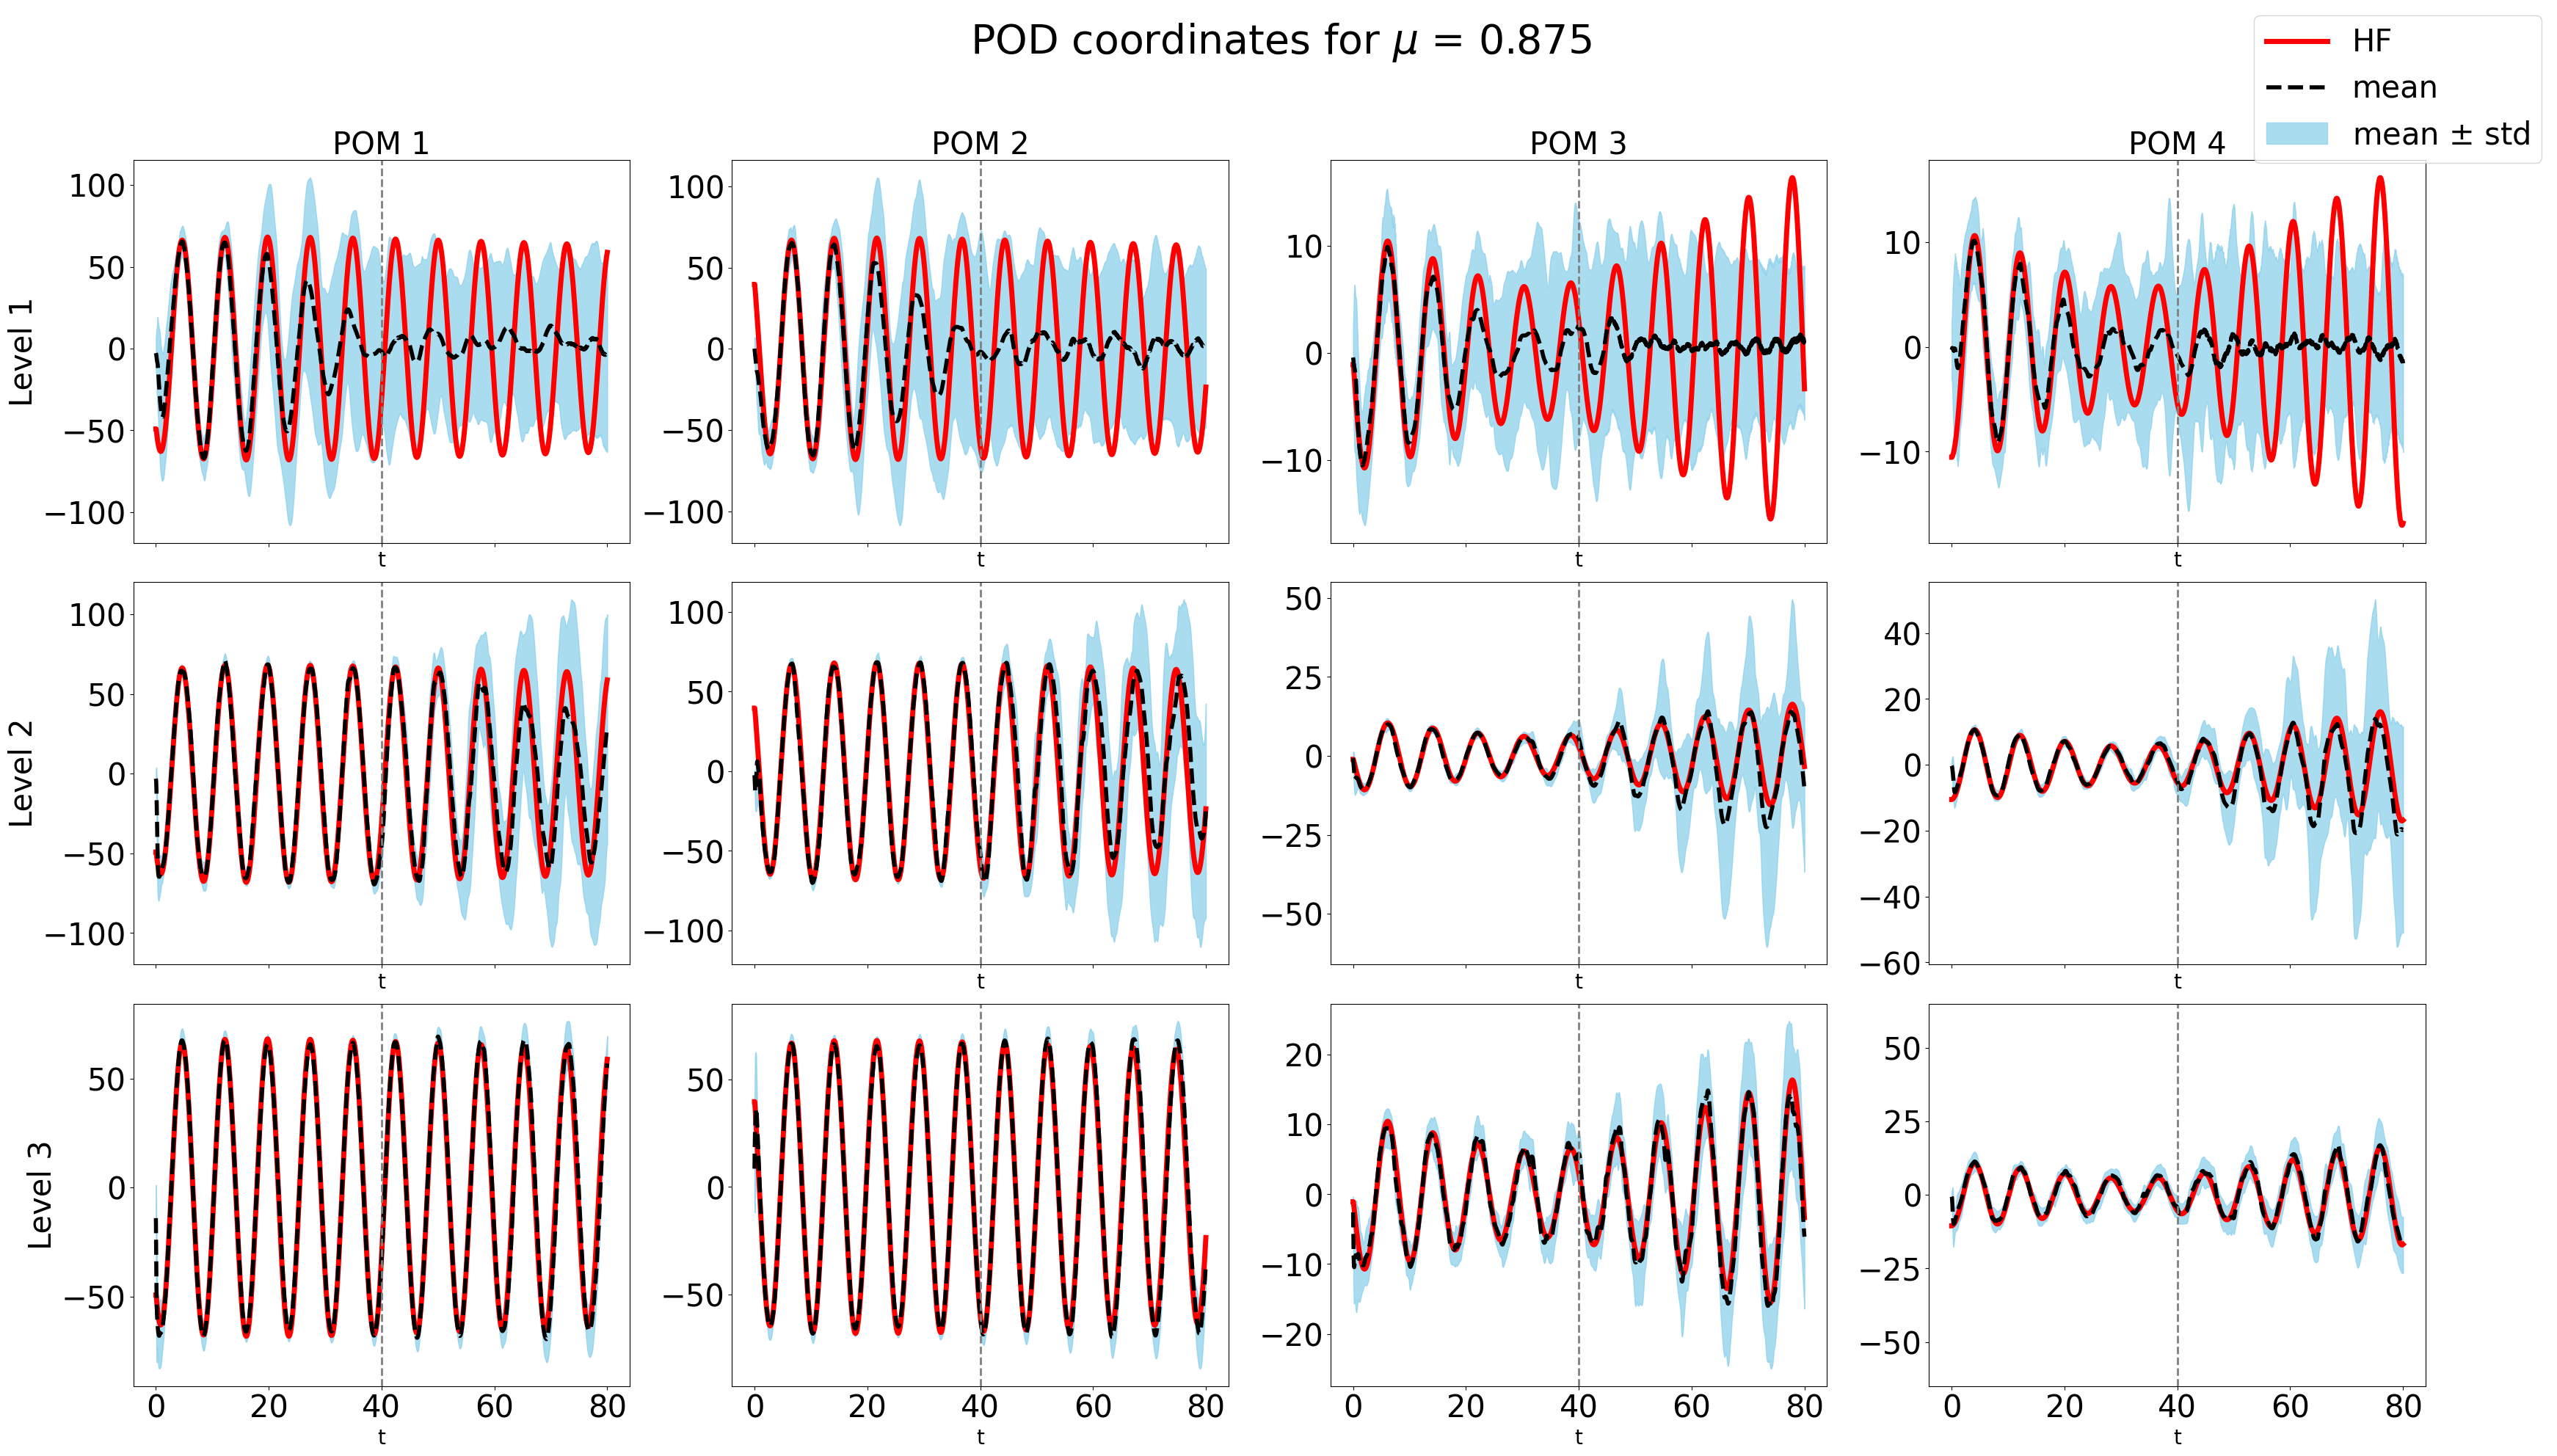

In [16]:
##########################   RESULTS POD COORDINATES   ##########################
idx_test = mu = 0
ylims = [[-120,120], [-120,120], [-65, 65], [-65,65]]


levels = {
    "Level 1": (mean_sim1, std_sim1),
    "Level 2": (mean_sim2, std_sim2),
    "Level 3": (mean_sim3, std_sim3),
}

fig, axes = plt.subplots(
    nrows=3, ncols=4, figsize=(35, 20), sharex=True, sharey=False
)
fig.suptitle(r'POD coordinates for $\mu$ = ' + str(mu_test[mu].round(3)), fontsize=40)

for row, (level_name, (mean_sim, std_sim)) in enumerate(levels.items()):
    for POD_mode in range(4):
        ax = axes[row, POD_mode]
        
        # HF curve
        ax.plot(t_test, y1_test_lstm[idx_test,:Nt_test, POD_mode] * scale,
                label='HF', color='red', linewidth=5)
        
        # Mean + std
        ax.plot(t_test, mean_sim[idx_test,:Nt_test, POD_mode],
                label='mean', color='black', linestyle='--', linewidth=4)
        ax.fill_between(t_test,
                        mean_sim[idx_test,:Nt_test, POD_mode] - 2*std_sim[idx_test,:Nt_test, POD_mode],
                        mean_sim[idx_test,:Nt_test, POD_mode] + 2*std_sim[idx_test,:Nt_test, POD_mode],
                        color='skyblue', alpha=0.7, label='mean $\pm$ std')
        
        # Training cutoff
        ax.axvline(x=T_train, linestyle='--', color='gray', linewidth=2)
        
        # Titles only on top row
        if row == 0:
            ax.set_title(f'POM {POD_mode + 1}', fontsize=30)
        # Y-label only on first column
        if POD_mode == 0:
            ax.set_ylabel(level_name, fontsize=30)
        
        ax.tick_params(axis='both', which='major', labelsize=30)
        ax.set_xlabel('t', fontsize=20)
        plt.ylim(ylims[POD_mode])

# Add legend only once
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=30)

plt.tight_layout(rect=[0, 0, .95, 0.95])
plt.savefig(config.FIGURE_PATH + '/results_POD_ReactionDiffusion.svg', bbox_inches='tight', dpi=600)
plt.show()

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:39: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\p'
<>:58: SyntaxWarning: invalid escape sequence '\m'
<>:64: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:39: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\p'
<>:58: SyntaxWarning: invalid escape sequence '\m'
<>:64: SyntaxWarning: invalid escape sequence '\p'
/var/folders/53/bl81mrf10js0l8nbft96cn9r0000gr/T/ipykernel_83162/1356688666.py:8: SyntaxWarning: invalid escape sequence '\m'
  plt.suptitle('Level 3: $\mu$ = ' + str(mu_test[mu].round(3)) + '\n', fontsize = 35)
/var/folders/53/bl81mrf10js0l8nbft96cn9r0000gr/T/ipykernel_83162/1356688666.py:14: SyntaxWarning: invalid escape sequence '\p'
  plt.fill_between(t_test, mean_sim3[idx_test,:Nt_t

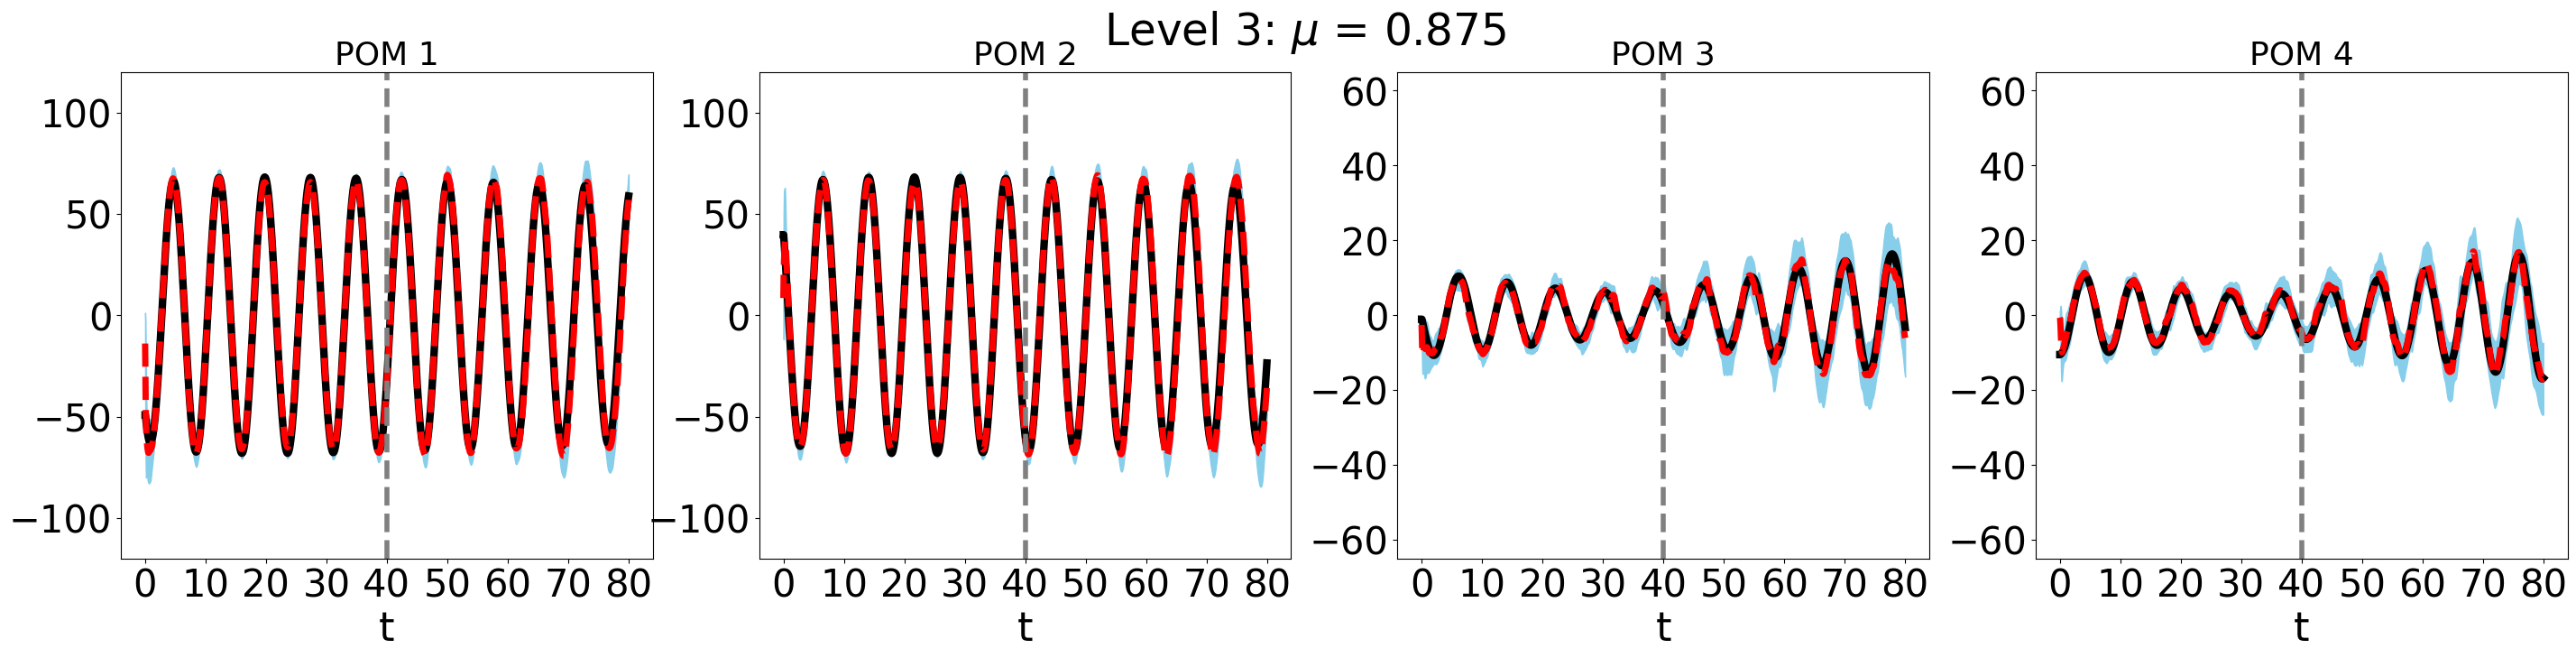

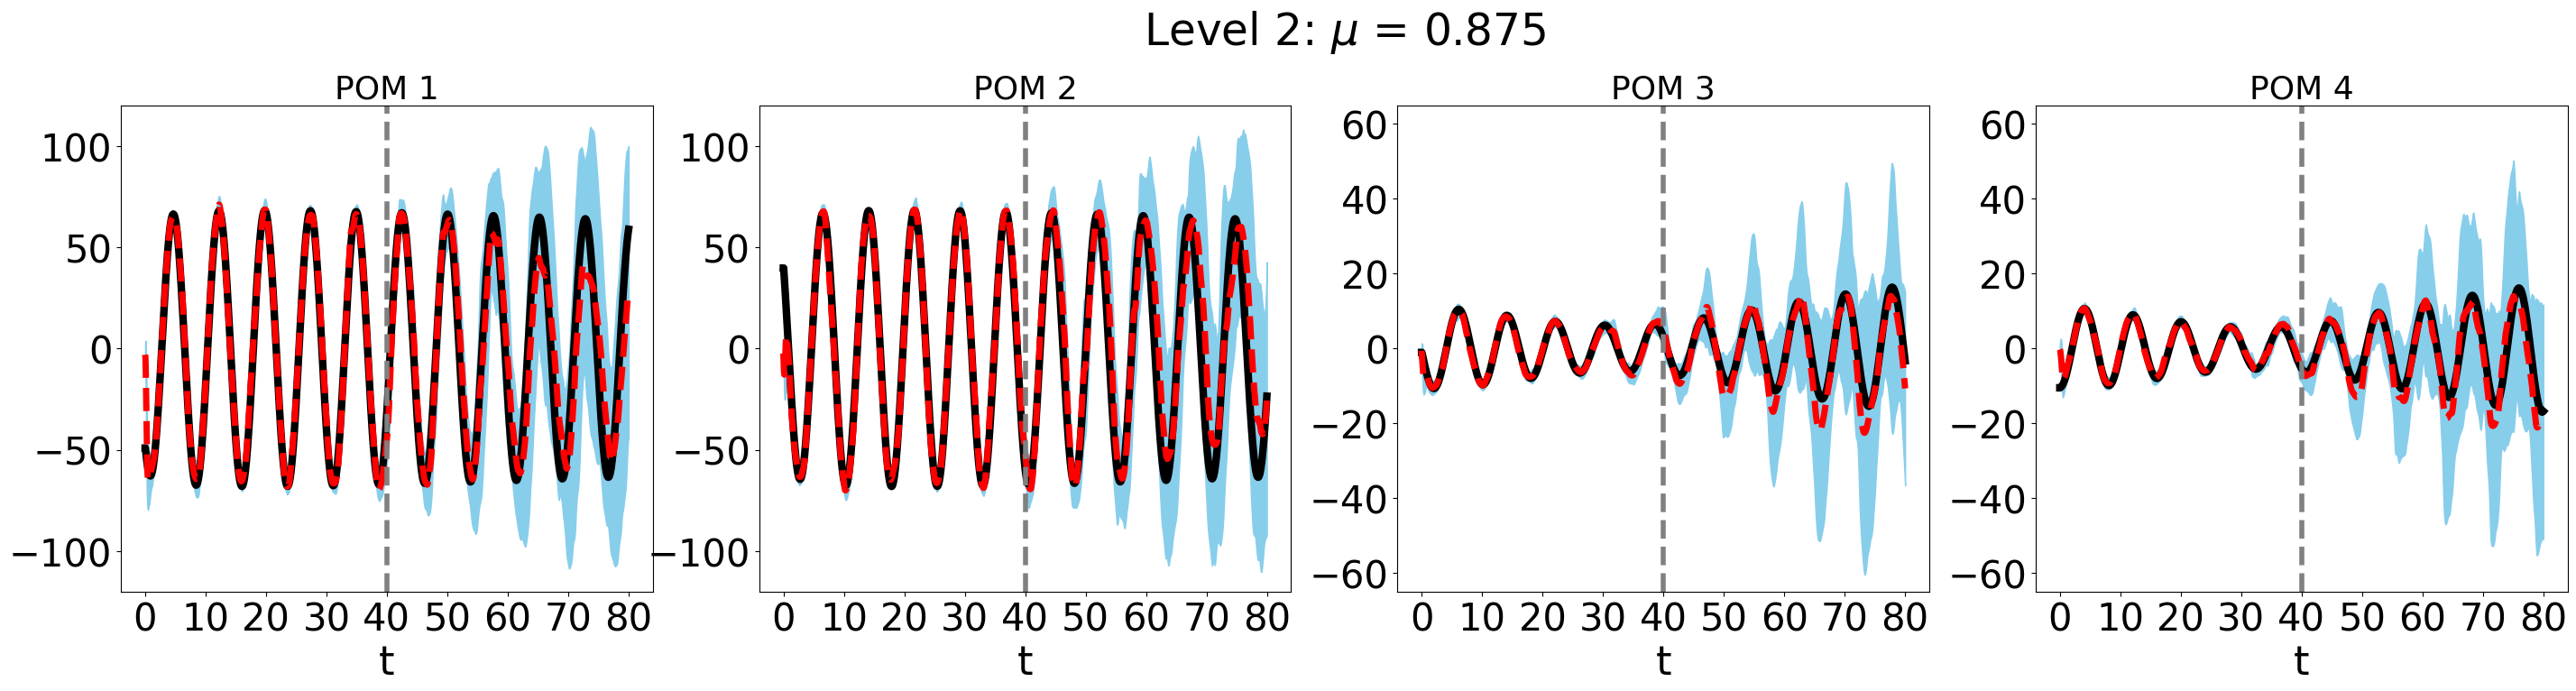

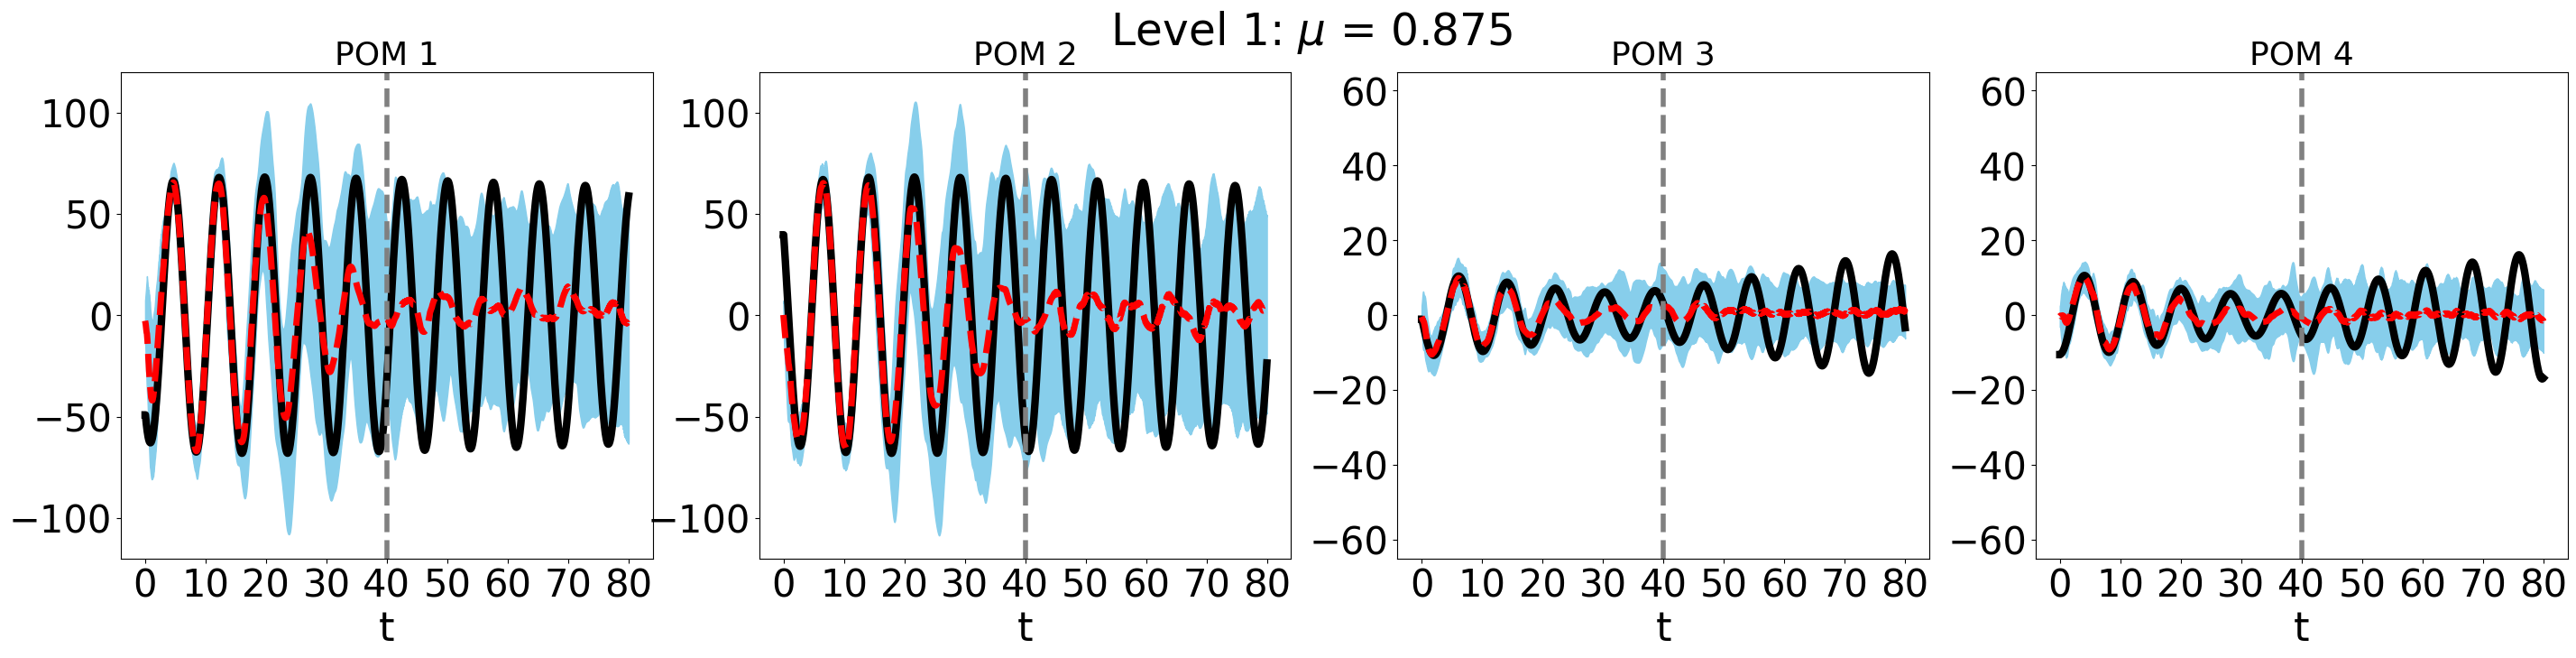

In [17]:
##########################   Compare results at different levels   ##########################
idx_test = mu = 0

ylims = [[-120,120], [-120,120], [-65, 65], [-65,65]]

# Level 3
fig = plt.figure(figsize=(35,7)) 
plt.suptitle('Level 3: $\mu$ = ' + str(mu_test[mu].round(3)) + '\n', fontsize = 35)
plt.axis('off')
for POD_mode in range(4):
    ax = fig.add_subplot(141 + POD_mode)
    plt.plot(t_test, y1_test_lstm[idx_test,:Nt_test, POD_mode] * scale, label = 'HF', color = 'black', linewidth = 6)
    plt.plot(t_test, mean_sim3[idx_test,:Nt_test, POD_mode], label = 'mean', color = 'red', linestyle = '--', linewidth = 5)
    plt.fill_between(t_test, mean_sim3[idx_test,:Nt_test, POD_mode] - 2*std_sim3[idx_test,:Nt_test, POD_mode], mean_sim3[idx_test,:Nt_test, POD_mode] + 2*std_sim3[idx_test,:Nt_test, POD_mode], color='skyblue', alpha=1., label='mean $\pm$ std')

    plt.axvline(x=T_train, linestyle='--', color='gray', linewidth = 4)
    ax.set_title('POM ' + str(POD_mode + 1), fontsize = 26)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.ylim(ylims[POD_mode])
    plt.xlabel('t', rotation=0, fontsize=32)
    #plt.legend(fontsize=26)

    # Add a common legend at the bottom center
    #if POD_mode == 0:
    #    fig.legend(
    #        loc='lower center',
    #        ncol=3,                 # horizontal alignment
    #        fontsize=26,
    #        frameon=True,           # rectangular box
    #        fancybox=False,
    #        edgecolor='black'
    #    )
plt.savefig(config.FIGURE_PATH + '/results_POD_3.svg', bbox_inches='tight', dpi=600)
plt.show()

# Level 2
fig = plt.figure(figsize=(35,7)) 
plt.title('Level 2: $\mu$ = ' + str(mu_test[mu].round(3)) + '\n', fontsize = 35)
plt.axis('off')
for POD_mode in range(4):
    ax = fig.add_subplot(141 + POD_mode)
    plt.plot(t_test, y1_test_lstm[idx_test, :Nt_test, POD_mode] * scale, label = 'HF', color = 'black', linewidth = 6)
    plt.plot(t_test, mean_sim2[idx_test,:Nt_test, POD_mode], label = 'mean', color = 'red', linestyle = '--', linewidth = 5)
    plt.fill_between(t_test, mean_sim2[idx_test,:Nt_test, POD_mode] - 2*std_sim2[idx_test,:Nt_test, POD_mode], mean_sim2[idx_test,:Nt_test, POD_mode] + 2*std_sim2[idx_test,:Nt_test, POD_mode], color='skyblue', alpha=1., label='mean $\pm$ std')

    plt.axvline(x=T_train, linestyle='--', color='gray', linewidth = 4)
    ax.set_title('POM ' + str(POD_mode + 1), fontsize = 26)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.ylim(ylims[POD_mode])
    plt.xlabel('t', rotation=0, fontsize=32)
plt.savefig(config.FIGURE_PATH + '/results_POD_2.svg', bbox_inches='tight', dpi=600)
plt.show()

# Level 1
fig = plt.figure(figsize=(35,7)) 
plt.suptitle(' Level 1: $\mu$ = ' + str(mu_test[mu].round(3)) + '\n', fontsize = 35)
plt.axis('off')
for POD_mode in range(4):
    ax = fig.add_subplot(141 + POD_mode)
    plt.plot(t_test, y1_test_lstm[idx_test,:Nt_test, POD_mode] * scale, label = 'HF', color = 'black', linewidth = 6)
    plt.plot(t_test,mean_sim1[idx_test,:Nt_test, POD_mode], label = 'mean', color = 'red', linestyle = '--', linewidth = 5)
    plt.fill_between(t_test, mean_sim1[idx_test,:Nt_test, POD_mode] -2*std_sim1[idx_test,:Nt_test, POD_mode], mean_sim1[idx_test,:Nt_test, POD_mode] + 2*std_sim1[idx_test,:Nt_test, POD_mode], color='skyblue', alpha=1., label='mean $\pm$ std')

    plt.axvline(x=T_train, linestyle='--', color='gray', linewidth = 4)
    ax.set_title('POM ' + str(POD_mode + 1), fontsize = 26)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.ylim(ylims[POD_mode])
    plt.xlabel('t', rotation=0, fontsize=32)
plt.savefig(config.FIGURE_PATH + '/results_POD_1.svg', bbox_inches='tight', dpi=600)
plt.show()

In [18]:
##########################   RECONSTRUCTION   ##########################
u_pred3 = (mean_sim3 @ POM_u.T).T.reshape(Nx_hf, Ny_hf, Nt_test, N_mu_test).swapaxes(0,1)
u_pred2 = (mean_sim2 @ POM_u.T).T.reshape(Nx_hf, Ny_hf, Nt_test, N_mu_test).swapaxes(0,1)
u_pred1 = (mean_sim1 @ POM_u.T).T.reshape(Nx_hf, Ny_hf, Nt_test, N_mu_test).swapaxes(0,1)

u_true = u_hf_test

print('Reconstruction errors:')
err_1_pod =  np.linalg.norm((mean_sim1 - y1_test_lstm * scale) ) / np.linalg.norm(y1_test_lstm * scale)
err_2_pod =  np.linalg.norm((mean_sim2 - y2_test_lstm * scale) ) / np.linalg.norm(y2_test_lstm * scale)
err_3_pod =  np.linalg.norm((mean_sim3 - y3_test_lstm * scale) ) / np.linalg.norm(y3_test_lstm * scale)
print("POD Coefficients Error Level 1: ", err_1_pod * 100, "%")
print("POD Coefficients Error Level 2: ", err_2_pod * 100, "%")
print("POD Coefficients Error Level 3: ", err_3_pod * 100, "%")

err_1 = np.linalg.norm(u_pred1 - u_true) / np.linalg.norm(u_true)
err_2 = np.linalg.norm(u_pred2 - u_true) / np.linalg.norm(u_true)
err_3 = np.linalg.norm(u_pred3 - u_true) / np.linalg.norm(u_true)
print("Error Level 1: ", err_1 * 100, "%")
print("Error Level 2: ", err_2 * 100, "%")
print("Error Level 3: ", err_3 * 100, "%")

Reconstruction errors:
POD Coefficients Error Level 1:  80.8878207161851 %
POD Coefficients Error Level 2:  25.67127573644617 %
POD Coefficients Error Level 3:  11.773134050295422 %
Error Level 1:  81.34128144040899 %
Error Level 2:  29.28788441286649 %
Error Level 3:  18.66671255547493 %


[400, 1000, 1400]


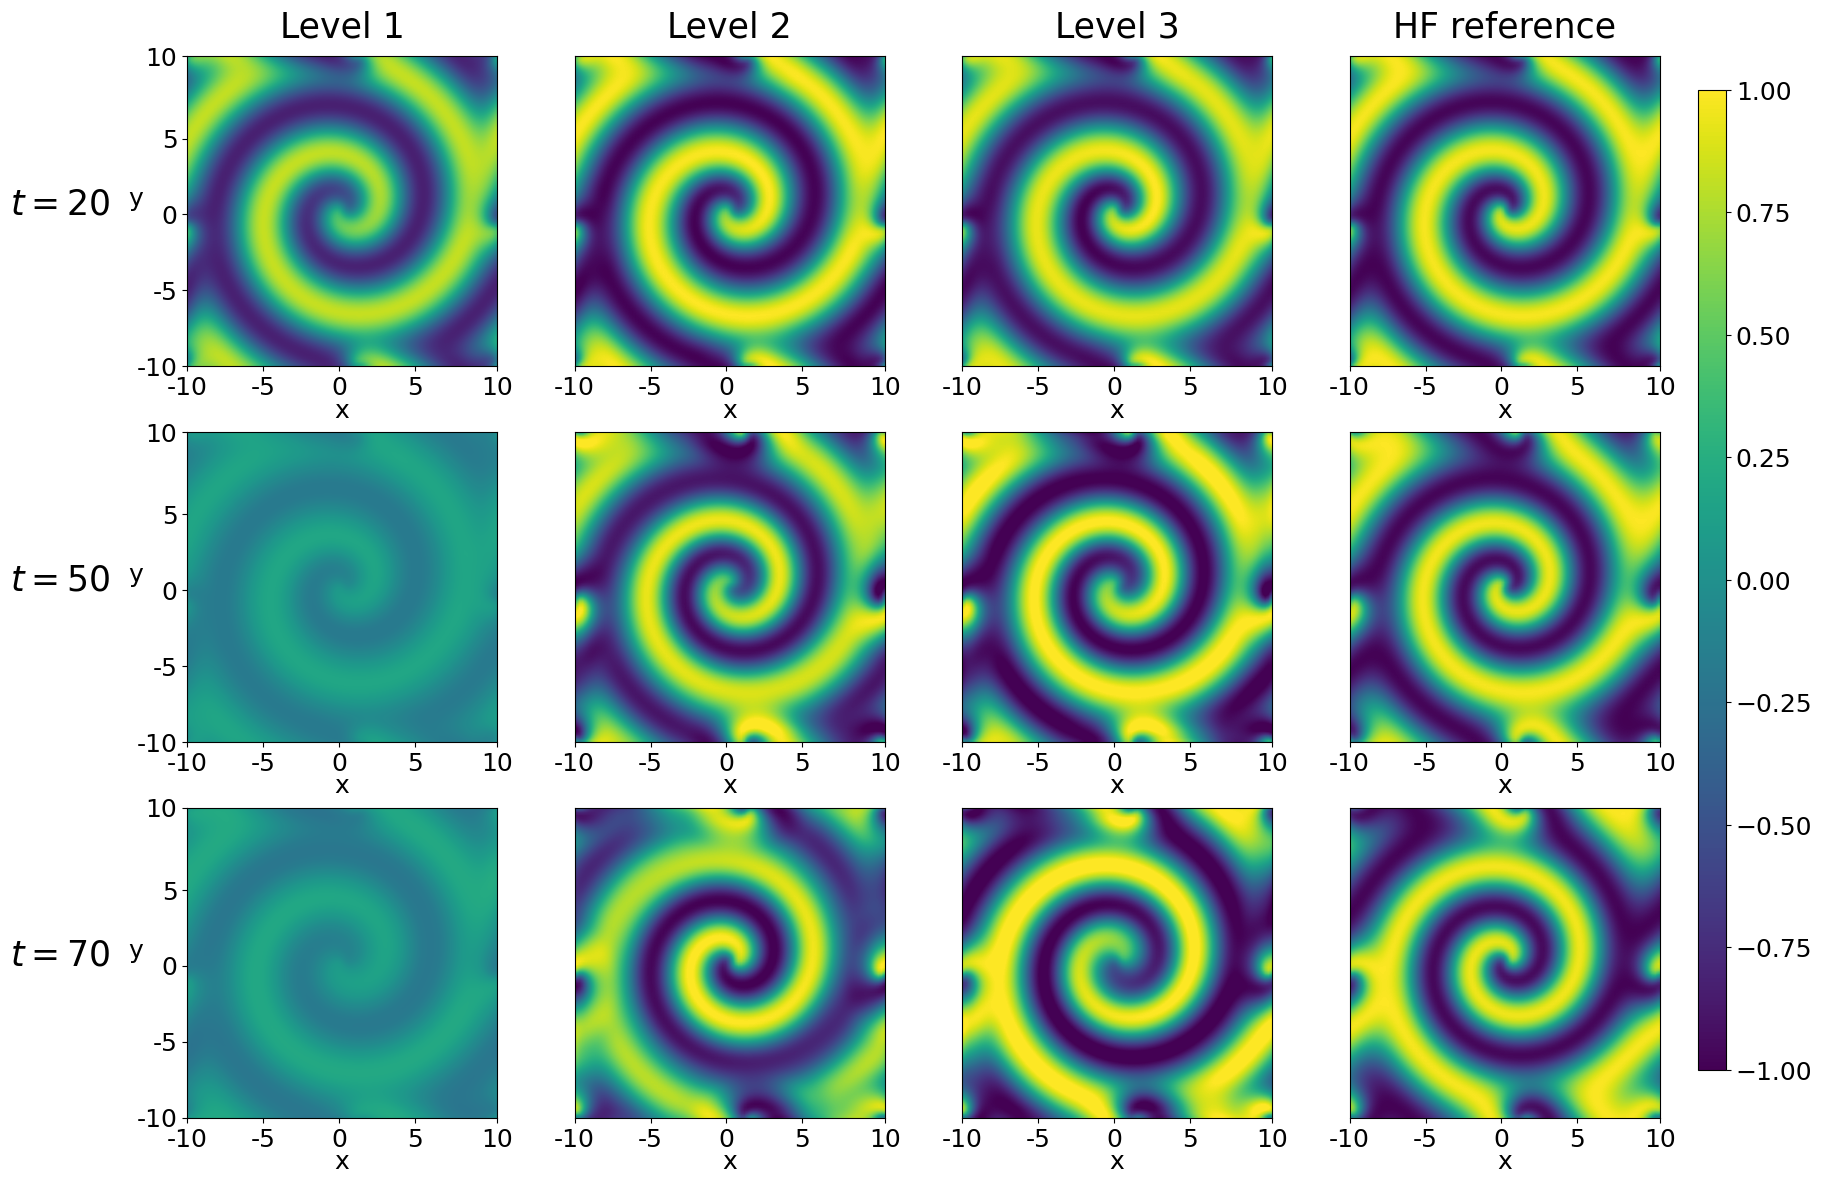

In [19]:

# Parameters
idx_test = 0
t_test_selected = [20, 50, 70]
fontsize = 18

# Find closest indices
ind_t_test = [np.argmin(np.abs(t_test - t)) for t in t_test_selected]
print(ind_t_test)

# Axis ticks
x_range = np.linspace(-10, 10, 5, dtype=int)
y_range = np.linspace(-10, 10, 5, dtype=int)
x_loc = np.linspace(0, 49, 5, dtype=int)
y_loc = np.linspace(0, 49, 5, dtype=int)

# Data mapping
levels = [
    ("Level 1", lambda t: u_pred1[:, :, t, idx_test]),
    ("Level 2", lambda t: u_pred2[:, :, t, idx_test]),
    ("Level 3", lambda t: u_pred3[:, :, t, idx_test]),
    ("HF reference", lambda t: u_true[:, :, t, idx_test])
]

# Figure setup
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(19, 14))
plt.subplots_adjust(wspace=0.25, hspace=0.15)

# Store the last colorbar mappable for a single shared colorbar
last_surf = None

for i, (t_idx, t_val) in enumerate(zip(ind_t_test, t_test_selected)):
    for j, (title, data_fn) in enumerate(levels):
        ax = axes[i, j]
        surf = ax.imshow(
            data_fn(t_idx),
            extent=[x_loc[0], x_loc[-1], x_loc[0], x_loc[-1]],
            origin='lower',
            interpolation='bilinear',
            vmin=-1.,
            vmax=1.
        )
        last_surf = surf  # keep reference for colorbar

        # Titles
        if i == 0:
            ax.set_title(title, fontsize=25, pad=14)

        # X label
        ax.set_xlabel('x', fontsize=fontsize, labelpad=-1)

        # Y label + ticks: only keep for first column
        if j == 0:
            ax.set_ylabel('y', fontsize=fontsize, labelpad=1, rotation=0)
            ax.set_yticks(y_loc)
            ax.set_yticklabels(y_range, fontsize=fontsize)
        else:
            ax.set_ylabel('')
            ax.set_yticks([])         
            ax.set_yticklabels([])    

        # Time annotation
        if j == 0:
            ax.text(-28, 24, f"$t = {t_val}$", fontsize=25)

        # X ticks
        ax.set_xticks(x_loc)
        ax.set_xticklabels(x_range, fontsize=fontsize)

cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(last_surf, cax=cbar_ax)
cbar.ax.tick_params(labelsize=fontsize)

# Save with transparent background
plt.savefig(
    config.FIGURE_PATH + f'/spatial_fields_{idx_test}.svg',
    transparent=True,
    bbox_inches='tight',
    dpi=600
)

plt.show()

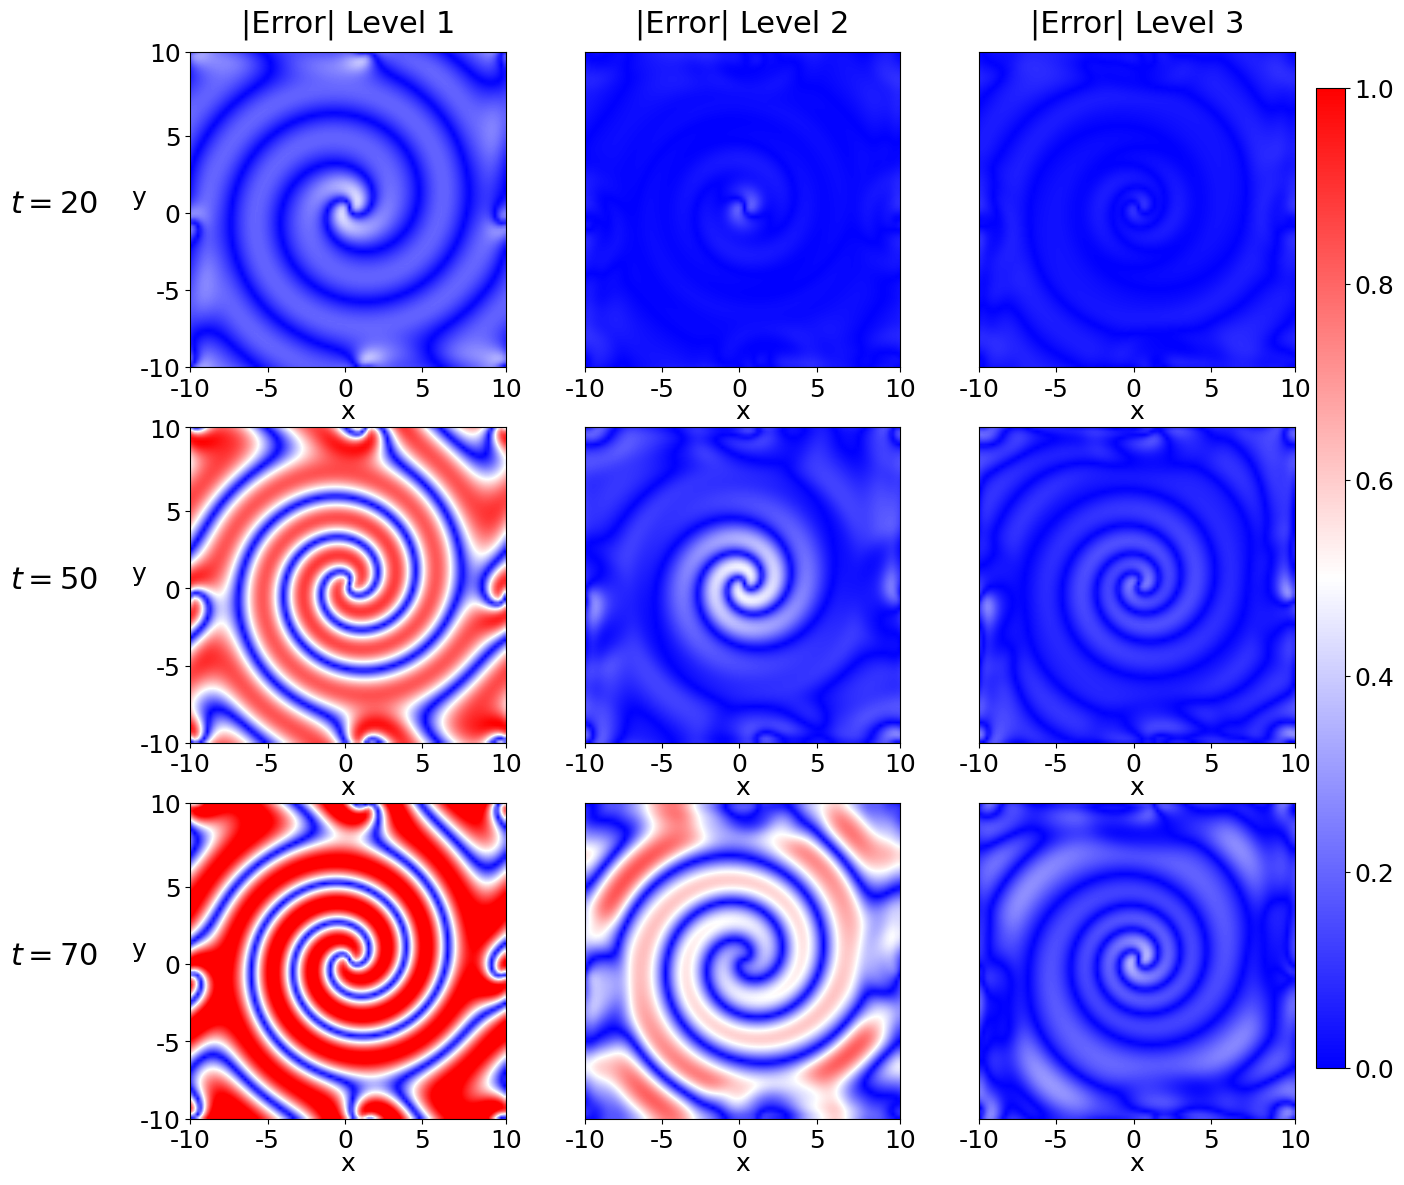

In [20]:
# Data mapping for errors
levels = [
    ("|Error| Level 1", lambda t: np.abs(u_pred1[:, :, t, idx_test] - u_true[:, :, t, idx_test])),
    ("|Error| Level 2", lambda t: np.abs(u_pred2[:, :, t, idx_test] - u_true[:, :, t, idx_test])),
    ("|Error| Level 3", lambda t: np.abs(u_pred3[:, :, t, idx_test] - u_true[:, :, t, idx_test])),
]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14.25, 14))  
plt.subplots_adjust(wspace=0.25, hspace=0.15)

last_surf = None

for i, (t_idx, t_val) in enumerate(zip(ind_t_test, t_test_selected)):
    for j, (title, data_fn) in enumerate(levels):
        ax = axes[i, j]
        err = data_fn(t_idx)

        # Plot absolute error
        surf = ax.imshow(
            err,
            extent=[x_loc[0], x_loc[-1], x_loc[0], x_loc[-1]],
            origin='lower',
            interpolation='bilinear',
            cmap='bwr',
            vmin=0,
            vmax=1.
        )
        last_surf = surf

        # Titles
        if i == 0:
            ax.set_title(title, fontsize=22, pad=14)

        # X label
        ax.set_xlabel('x', fontsize=fontsize, labelpad=-1)

        # Y label + ticks only for first column
        if j == 0:
            ax.set_ylabel('y', fontsize=fontsize, labelpad=1, rotation=0)
            ax.text(-28, 24, f"$t = {t_val}$", fontsize=22)
            ax.set_yticks(y_loc)
            ax.set_yticklabels(y_range, fontsize=fontsize)
        else:
            ax.set_ylabel('')
            ax.set_yticks([])
            ax.set_yticklabels([])

        ax.set_xticks(x_loc)
        ax.set_xticklabels(x_range, fontsize=fontsize)

cbar_ax = fig.add_axes([0.915, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(last_surf, cax=cbar_ax)
cbar.ax.tick_params(labelsize=fontsize)

plt.savefig(
    config.FIGURE_PATH + f'/spatial_fields_error_{idx_test}.svg',
    transparent=True,
    bbox_inches='tight',
    dpi=600
)

plt.show()